# Telecom churn Case Study

### Approach

#### 1. Importing Data, Data Preparation
- Filtering High Value Customers
- Dropping Features with no variance
- Deriving New Features
- Labelling Churned Status
- Missing Value Treatment
- Outlier Treatment
- Checking Correlation
- Bivariate and Multivariate Analysis
- Splitting data into Training and Test set
- Feature Scaling
- Data Imbalance Treatment


#### 2. Building predictor Model
- Finding optimum number of principal components
- Build Logistic Regression model with optimum cutoff and calculate performance metrics
- Build Decision Tree model with best parameters and calculate performance metrics
- Build Random Forest Classifier model with best parameters and calculate performance metrics
- Build XGBoost Classifier model with best parameters and calculate performance metrics
- Compare performance metrices to build final model


#### 3. Building interpretable model
- Obtain top n features by RFE
- Optimize the model further by inspecting VIF and p-vales
- Build model with final set of features
- Visualize the features' impact on churn


#### 4. Business Recommendation

# Importing Data, Data Preparation

In [321]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import IncrementalPCA

# Model Building
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Setting maximum number of rows/columns to display in DataFrame
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

In [322]:
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [323]:
telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [324]:
telecom.shape

(99999, 226)

In [325]:
# Checking the missing values in columns
telecom.isna().mean(axis = 0).sort_values(ascending = False) * 100

arpu_3g_6                   74.846748
night_pck_user_6            74.846748
total_rech_data_6           74.846748
arpu_2g_6                   74.846748
max_rech_data_6             74.846748
fb_user_6                   74.846748
av_rech_amt_data_6          74.846748
date_of_last_rech_data_6    74.846748
count_rech_2g_6             74.846748
count_rech_3g_6             74.846748
date_of_last_rech_data_7    74.428744
total_rech_data_7           74.428744
fb_user_7                   74.428744
max_rech_data_7             74.428744
night_pck_user_7            74.428744
count_rech_2g_7             74.428744
av_rech_amt_data_7          74.428744
arpu_2g_7                   74.428744
count_rech_3g_7             74.428744
arpu_3g_7                   74.428744
total_rech_data_9           74.077741
count_rech_3g_9             74.077741
fb_user_9                   74.077741
max_rech_data_9             74.077741
arpu_3g_9                   74.077741
date_of_last_rech_data_9    74.077741
night_pck_us

In [326]:
# Setting mobile_number as index as it is a unique identifier for each customer
telecom = telecom.set_index('mobile_number')

## Filtering High Value Customers

Filtering high-value customers from the given dataset. Further analysis will be conducted exclusively on high-value customers.

High Value Customers : Those who have recharged with an amount more than or equal to 70th percentile of the average recharge amount in the first two months (the good phase).

In [327]:
print(telecom.av_rech_amt_data_6.isnull().mean()*100)
print(telecom.av_rech_amt_data_7.isnull().mean()*100)

telecom[['av_rech_amt_data_6', 'av_rech_amt_data_7']].describe()

74.84674846748467
74.42874428744287


,av_rech_amt_data_6,av_rech_amt_data_7
count,25153.000000,25571.000000
mean,192.600982,200.981292
std,192.646318,196.791224
min,1.000000,0.500000
25%,82.000000,92.000000
50%,154.000000,154.000000
75%,252.000000,252.000000
max,7546.000000,4365.000000


From the statistical summary, it's evident that when a customer didn't make a recharge, the recharge data is missing. Therefore, imputing values of 0 in the two columns is appropriate.

In [328]:
#Imputing the Null values with 0
telecom.av_rech_amt_data_7=telecom.av_rech_amt_data_7.fillna(0)
telecom.av_rech_amt_data_6=telecom.av_rech_amt_data_6.fillna(0)

telecom['av_rech_amt_data_6_7']=(telecom.av_rech_amt_data_6+telecom.av_rech_amt_data_7)/2

High_value_customers = telecom[telecom.av_rech_amt_data_6_7 >= telecom.av_rech_amt_data_6_7.quantile(.70)]
High_value_customers.drop('av_rech_amt_data_6_7',axis=1,inplace=True)
print(High_value_customers.shape)

(30378, 225)


## Dropping Features with Insignificant Variability

In [329]:
# Identifying highly skewed features, features having fixed values in all rows

skewed = []
for column in High_value_customers.columns:
    if High_value_customers[column].nunique() == 1:
        skewed.append(column)
print(skewed)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


We will remove all the above highly skewed features that have only one value across all rows (excluding missing data), as they will not contribute to the analysis.

In [330]:
High_value_customers.drop(skewed,axis=1,inplace=True)

In [331]:
High_value_customers.shape

(30378, 209)

Now, we'll utilize a separate DataFrame containing recharge dates to extract the number of days since the last recharge, whether it was for data or normal usage.

## Deriving New Features

In [332]:
# Taking Recharge Date Related Features into a New DataFrame for Deriving New Features
rech_df = High_value_customers[['date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']]

In [333]:
for feat in rech_df.columns:
    print(feat,"-", rech_df[feat].isnull().sum())

date_of_last_rech_data_6 - 6147
date_of_last_rech_data_7 - 5689
date_of_last_rech_data_8 - 9877
date_of_last_rech_6 - 171
date_of_last_rech_7 - 217
date_of_last_rech_8 - 758


In [334]:
rech_df.head()

,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
mobile_number,,,,,,
7000842753,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7001865778,NaN,7/25/2014,8/10/2014,6/29/2014,7/31/2014,8/28/2014
7000142493,6/4/2014,NaN,NaN,6/26/2014,7/28/2014,8/9/2014
7001524846,NaN,7/31/2014,8/23/2014,6/25/2014,7/31/2014,8/30/2014
7001864400,NaN,7/23/2014,NaN,6/29/2014,7/23/2014,8/29/2014


In [335]:
# Converting strings to datetime object for convenience
import datetime
for feat in rech_df.columns:
    rech_df[feat] = pd.to_datetime(rech_df[feat])

In [336]:
rech_df.head()

,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
mobile_number,,,,,,
7000842753,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7001865778,NaT,2014-07-25,2014-08-10,2014-06-29,2014-07-31,2014-08-28
7000142493,2014-06-04,NaT,NaT,2014-06-26,2014-07-28,2014-08-09
7001524846,NaT,2014-07-31,2014-08-23,2014-06-25,2014-07-31,2014-08-30
7001864400,NaT,2014-07-23,NaT,2014-06-29,2014-07-23,2014-08-29


In [337]:
rech_df['date_of_last_rech_data'] = rech_df['date_of_last_rech_data_8']
rech_df['date_of_last_rech'] = rech_df['date_of_last_rech_8']

In [338]:
rech_df.columns

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data',
       'date_of_last_rech'],
      dtype='object')

In [339]:
# If last data recharge date not in month=8, then check month 7 and 6
rech_df['date_of_last_rech_data'] = rech_df['date_of_last_rech_data_8'].fillna(rech_df['date_of_last_rech_data_7']).fillna(rech_df['date_of_last_rech_data_6'])

# If last normal recharge date not in month=8, then check month 7 and 6
rech_df['date_of_last_rech'] = rech_df['date_of_last_rech_8'].fillna(rech_df['date_of_last_rech_7']).fillna(rech_df['date_of_last_rech_6'])

In [340]:
rech_df.head()

,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data,date_of_last_rech
mobile_number,,,,,,,,
7000842753,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08,2014-08-08,2014-08-08
7001865778,NaT,2014-07-25,2014-08-10,2014-06-29,2014-07-31,2014-08-28,2014-08-10,2014-08-28
7000142493,2014-06-04,NaT,NaT,2014-06-26,2014-07-28,2014-08-09,2014-06-04,2014-08-09
7001524846,NaT,2014-07-31,2014-08-23,2014-06-25,2014-07-31,2014-08-30,2014-08-23,2014-08-30
7001864400,NaT,2014-07-23,NaT,2014-06-29,2014-07-23,2014-08-29,2014-07-23,2014-08-29


The last recharge date is determined as the most recent recharge date available in the dataset, considering data from months 6, 7, and 8.

In [341]:
rech_df[['date_of_last_rech', 'date_of_last_rech_data']].isnull().sum()

date_of_last_rech         0
date_of_last_rech_data    0
dtype: int64

In [342]:
# Using September 1st as the reference date to count the number of days since the last recharge
rech_df['ref_date'] = pd.to_datetime(datetime.date(2014, 9, 1))

# For data recharge
rech_df['no_of_days_since_last_rech_data'] = (rech_df['ref_date'] - rech_df['date_of_last_rech_data']).astype('timedelta64[D]')

# For normal recharge
rech_df['no_of_days_since_last_rech'] = (rech_df['ref_date'] - rech_df['date_of_last_rech']).astype('timedelta64[D]')
rech_df.head()

,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data,date_of_last_rech,ref_date,no_of_days_since_last_rech_data,no_of_days_since_last_rech
mobile_number,,,,,,,,,,,
7000842753,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08,2014-08-08,2014-08-08,2014-09-01,24.0,24.0
7001865778,NaT,2014-07-25,2014-08-10,2014-06-29,2014-07-31,2014-08-28,2014-08-10,2014-08-28,2014-09-01,22.0,4.0
7000142493,2014-06-04,NaT,NaT,2014-06-26,2014-07-28,2014-08-09,2014-06-04,2014-08-09,2014-09-01,89.0,23.0
7001524846,NaT,2014-07-31,2014-08-23,2014-06-25,2014-07-31,2014-08-30,2014-08-23,2014-08-30,2014-09-01,9.0,2.0
7001864400,NaT,2014-07-23,NaT,2014-06-29,2014-07-23,2014-08-29,2014-07-23,2014-08-29,2014-09-01,40.0,3.0


In [343]:
rech_df[['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].isnull().sum()

no_of_days_since_last_rech         0
no_of_days_since_last_rech_data    0
dtype: int64

In [344]:
High_value_customers['no_of_days_since_last_rech'] = rech_df['no_of_days_since_last_rech']
High_value_customers['no_of_days_since_last_rech_data'] = rech_df['no_of_days_since_last_rech_data']

In [345]:
High_value_customers[['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].head()

,no_of_days_since_last_rech,no_of_days_since_last_rech_data
mobile_number,,
7000842753,24.0,24.0
7001865778,4.0,22.0
7000142493,23.0,89.0
7001524846,2.0,9.0
7001864400,3.0,40.0


Dropping the original features since new features have been extracted.

In [346]:
High_value_customers.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis=1, inplace=True)

In [347]:
High_value_customers.shape

(30378, 205)

In [348]:
# Checking common features present for the 6th and 7th months
print(High_value_customers.columns[High_value_customers.columns.str.contains("_6", case=False)])
print(High_value_customers.columns[High_value_customers.columns.str.contains("_7", case=False)])

# Counting the number of common features for the 6th and 7th months
print(len(High_value_customers.columns[High_value_customers.columns.str.contains("_6", case=False)]))
print(len(High_value_customers.columns[High_value_customers.columns.str.contains("_7", case=False)]))

Index(['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6',
       'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6',
       'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6',
       'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6',
       'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6',
       'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6',
       'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6',
       'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6',
       'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6',
       'night_pck_user_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6',
       'sachet_3g_6', 'fb_user_6'],
      dtype='object')
Index(['arpu

- **For comparison of the data between the good phase (6th and 7th months) and the action phase (8th month), the average usage of the 6th and 7th months is calculated and then subtracted the usage of the 8th month from it.**
- **A positive value of the derived feature indicates a increase in usage from the good phase to the action phase (i.e., the average usage of the 6th and 7th months is more than the usage of the 8th month).**
- **A negative value indicates an decrease in usage during the action phase.**
- **Features prefixed with 'derived_' in their names are derived as described above.**

In [349]:
# Extracting features common in the 6th, 7th, and 8th months
features = zip(
    High_value_customers.columns[High_value_customers.columns.str.contains("_6", case=False)],
    High_value_customers.columns[High_value_customers.columns.str.contains("_7", case=False)],
    High_value_customers.columns[High_value_customers.columns.str.contains("_8", case=False)]
)

monthly_features = list(features)

# Iterating over the monthly features to derive new features
for i in range(len(monthly_features)):
    feat_6 = monthly_features[i][0]
    feat_7 = monthly_features[i][1]
    feat_8 = monthly_features[i][2]
  
    # Creating a new feature name
    new_feat_name = 'derived_' + feat_6[:-2]
    
    # Calculating the derived feature
    High_value_customers[new_feat_name] = ((High_value_customers[feat_6] + High_value_customers[feat_7]) / 2) - High_value_customers[feat_8]

    # Dropping the individual month features after deriving new features
    High_value_customers.drop([feat_6, feat_7, feat_8], axis=1, inplace=True)


In [350]:
High_value_customers.shape

(30378, 107)

The column 'churn' is derived based on the provided definition.

**Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.**

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

## Labelling Churn Status

In [351]:
# Initializing the 'churned' column with 0
High_value_customers = High_value_customers.assign(churned=0)

# List of column names to check for churn condition
columns_to_check = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']

# Building the condition for churned customers
condition = (High_value_customers[columns_to_check] == 0).all(axis=1)

# Labeling churned customers
High_value_customers.loc[condition, 'churned'] = 1

# Displaying the count of churned and non-churned customers
High_value_customers['churned'].value_counts()

0    27811
1     2567
Name: churned, dtype: int64

In [352]:
# Checking features given for month 9
feat_9 = High_value_customers.columns[High_value_customers.columns.str.contains("_9", case=False)]
print(feat_9)
print(len(feat_9))

# Dropping the features of the churned month as churn has been labelled
High_value_customers.drop(feat_9, axis=1, inplace=True)


Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9',
       'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9',
       'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9',
       'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9',
       'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9

In [353]:
High_value_customers.shape

(30378, 57)

In [354]:
High_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30378 entries, 7000842753 to 7001905007
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   aon                              30378 non-null  int64  
 1   aug_vbc_3g                       30378 non-null  float64
 2   jul_vbc_3g                       30378 non-null  float64
 3   jun_vbc_3g                       30378 non-null  float64
 4   sep_vbc_3g                       30378 non-null  float64
 5   no_of_days_since_last_rech       30378 non-null  float64
 6   no_of_days_since_last_rech_data  30378 non-null  float64
 7   derived_arpu                     30378 non-null  float64
 8   derived_onnet_mou                27897 non-null  float64
 9   derived_offnet_mou               27897 non-null  float64
 10  derived_roam_ic_mou              27897 non-null  float64
 11  derived_roam_og_mou              27897 non-null  float64
 12  deri

In [355]:
High_value_customers['derived_vbc_3g'] =(High_value_customers[['jun_vbc_3g', 'jul_vbc_3g']].mean(axis=1)) - High_value_customers['aug_vbc_3g']


In [356]:
High_value_customers[['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g', 'derived_vbc_3g']].head()

,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g,derived_vbc_3g
mobile_number,,,,
7000842753,101.20,0.00,30.40,20.200
7001865778,0.00,0.00,0.00,0.000
7000142493,0.00,0.00,0.00,0.000
7001524846,122.16,910.65,21.03,495.375
7001864400,0.00,0.00,0.00,0.000


In [357]:
# Create a list of redundant columns
columns_to_drop = ['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g', 'sep_vbc_3g']

# Dropping those columns 
High_value_customers.drop(columns=[col for col in columns_to_drop], axis=1, inplace=True)

High_value_customers.head()

,aon,no_of_days_since_last_rech,no_of_days_since_last_rech_data,derived_arpu,derived_onnet_mou,derived_offnet_mou,derived_roam_ic_mou,derived_roam_og_mou,derived_loc_og_t2t_mou,derived_loc_og_t2m_mou,derived_loc_og_t2f_mou,derived_loc_og_t2c_mou,derived_loc_og_mou,derived_std_og_t2t_mou,derived_std_og_t2m_mou,derived_std_og_t2f_mou,derived_std_og_mou,derived_isd_og_mou,derived_spl_og_mou,derived_og_others,derived_total_og_mou,derived_loc_ic_t2t_mou,derived_loc_ic_t2m_mou,derived_loc_ic_t2f_mou,derived_loc_ic_mou,derived_std_ic_t2t_mou,derived_std_ic_t2m_mou,derived_std_ic_t2f_mou,derived_std_ic_mou,derived_total_ic_mou,derived_spl_ic_mou,derived_isd_ic_mou,derived_ic_others,derived_total_rech_num,derived_total_rech_amt,derived_max_rech_amt,derived_last_day_rch_amt,derived_total_rech_data,derived_max_rech_data,derived_count_rech_2g,derived_count_rech_3g,derived_av_rech_amt_data,derived_vol_2g_mb,derived_vol_3g_mb,derived_arpu_3g,derived_arpu_2g,derived_night_pck_user,derived_monthly_2g,derived_sachet_2g,derived_monthly_3g,derived_sachet_3g,derived_fb_user,churned,derived_vbc_3g
mobile_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7000842753,968,24.0,24.0,-7.7025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.440,NaN,NaN,NaN,1.5,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,20.200
7001865778,1006,4.0,22.0,-73.7605,43.715,-246.970,0.0,0.0,41.540,-248.135,0.0,1.455,-206.590,2.170,0.100,0.0,2.275,0.0,1.295,0.0,-203.020,-13.470,-334.15,0.855,-346.770,-2.35,-9.540,0.0,-11.890,-357.750,0.0,0.915,0.00,-4.5,-54.0,34.0,3.5,NaN,NaN,NaN,NaN,27.0,-311.435,0.000,NaN,NaN,NaN,0.5,-2.0,0.0,0.0,NaN,0,0.000
7000142493,1526,23.0,89.0,47.5820,15.985,-39.840,0.0,0.0,15.985,-44.500,0.0,0.000,-28.515,0.000,4.655,0.0,4.655,0.0,0.000,0.0,-23.855,-136.725,4.06,0.750,-131.905,-0.86,1.090,0.0,0.230,-131.445,0.0,0.000,0.24,2.5,-14.0,-27.0,-30.0,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.0,0.5,0.0,0.0,NaN,0,0.000
7001524846,315,2.0,9.0,298.1100,347.280,-48.835,0.0,0.0,244.870,25.230,0.0,-7.150,270.095,102.415,-63.825,0.0,38.590,0.0,-10.230,0.0,298.450,16.530,20.30,0.000,36.840,0.19,12.605,0.0,12.795,49.635,0.0,0.000,0.00,6.0,399.0,92.0,15.0,NaN,NaN,NaN,NaN,19.5,177.970,363.535,NaN,NaN,NaN,0.5,-2.5,0.0,0.0,NaN,0,495.375
7001864400,902,3.0,40.0,13.2455,9.570,-19.520,0.0,0.0,9.570,4.115,0.0,0.000,13.695,0.000,-23.640,0.0,-23.640,0.0,0.330,0.0,-9.620,76.910,-7.99,0.200,69.130,0.15,53.795,0.0,53.945,95.785,0.0,-27.290,0.00,-2.0,-2.5,82.0,102.0,NaN,NaN,NaN,NaN,NaN,3.685,0.000,NaN,NaN,NaN,0.5,0.0,0.0,0.0,NaN,0,0.000


## Missing Value Treatment

In [366]:
missing_values = []
for feat in High_value_customers.columns:
    if(High_value_customers[feat].isnull().mean() > 0.40):
        print(feat, round(High_value_customers[feat].isnull().mean(),2))
        missing_values.append(feat)

derived_total_rech_data 0.4989
derived_max_rech_data 0.4989
derived_count_rech_2g 0.4989
derived_count_rech_3g 0.4989
derived_arpu_3g 0.4989
derived_arpu_2g 0.4989
derived_night_pck_user 0.4989
derived_fb_user 0.4989


In [367]:
# Drop features with high missing values
High_value_customers.drop(missing_values, axis=1, inplace=True)
High_value_customers.head()

,aon,no_of_days_since_last_rech,no_of_days_since_last_rech_data,derived_arpu,derived_onnet_mou,derived_offnet_mou,derived_roam_ic_mou,derived_roam_og_mou,derived_loc_og_t2t_mou,derived_loc_og_t2m_mou,derived_loc_og_t2f_mou,derived_loc_og_t2c_mou,derived_loc_og_mou,derived_std_og_t2t_mou,derived_std_og_t2m_mou,derived_std_og_t2f_mou,derived_std_og_mou,derived_isd_og_mou,derived_spl_og_mou,derived_og_others,derived_total_og_mou,derived_loc_ic_t2t_mou,derived_loc_ic_t2m_mou,derived_loc_ic_t2f_mou,derived_loc_ic_mou,derived_std_ic_t2t_mou,derived_std_ic_t2m_mou,derived_std_ic_t2f_mou,derived_std_ic_mou,derived_total_ic_mou,derived_spl_ic_mou,derived_isd_ic_mou,derived_ic_others,derived_total_rech_num,derived_total_rech_amt,derived_max_rech_amt,derived_last_day_rch_amt,derived_av_rech_amt_data,derived_vol_2g_mb,derived_vol_3g_mb,derived_monthly_2g,derived_sachet_2g,derived_monthly_3g,derived_sachet_3g,churned,derived_vbc_3g
mobile_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7000842753,968,24.0,24.0,-7.7025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.440,NaN,NaN,NaN,1.5,55.0,0.0,0.0,0.0,9.975,7.555,0.0,0.0,0.0,0.0,1,20.200
7001865778,1006,4.0,22.0,-73.7605,43.715,-246.970,0.0,0.0,41.540,-248.135,0.0,1.455,-206.590,2.170,0.100,0.0,2.275,0.0,1.295,0.0,-203.020,-13.470,-334.15,0.855,-346.770,-2.35,-9.540,0.0,-11.890,-357.750,0.0,0.915,0.00,-4.5,-54.0,34.0,3.5,27.0,-311.435,0.000,0.5,-2.0,0.0,0.0,0,0.000
7000142493,1526,23.0,89.0,47.5820,15.985,-39.840,0.0,0.0,15.985,-44.500,0.0,0.000,-28.515,0.000,4.655,0.0,4.655,0.0,0.000,0.0,-23.855,-136.725,4.06,0.750,-131.905,-0.86,1.090,0.0,0.230,-131.445,0.0,0.000,0.24,2.5,-14.0,-27.0,-30.0,NaN,0.000,0.000,0.0,0.5,0.0,0.0,0,0.000
7001524846,315,2.0,9.0,298.1100,347.280,-48.835,0.0,0.0,244.870,25.230,0.0,-7.150,270.095,102.415,-63.825,0.0,38.590,0.0,-10.230,0.0,298.450,16.530,20.30,0.000,36.840,0.19,12.605,0.0,12.795,49.635,0.0,0.000,0.00,6.0,399.0,92.0,15.0,19.5,177.970,363.535,0.5,-2.5,0.0,0.0,0,495.375
7001864400,902,3.0,40.0,13.2455,9.570,-19.520,0.0,0.0,9.570,4.115,0.0,0.000,13.695,0.000,-23.640,0.0,-23.640,0.0,0.330,0.0,-9.620,76.910,-7.99,0.200,69.130,0.15,53.795,0.0,53.945,95.785,0.0,-27.290,0.00,-2.0,-2.5,82.0,102.0,NaN,3.685,0.000,0.5,0.0,0.0,0.0,0,0.000


In [369]:
# Remaining features for Missing Value Imputation
missing_values = []
for feat in High_value_customers.columns:
    if 0 < High_value_customers[feat].isnull().mean() < 0.4:
        missing_values.append(feat)
        print(feat, round(High_value_customers[feat].isnull().mean(), 2))

derived_onnet_mou 0.08
derived_offnet_mou 0.08
derived_roam_ic_mou 0.08
derived_roam_og_mou 0.08
derived_loc_og_t2t_mou 0.08
derived_loc_og_t2m_mou 0.08
derived_loc_og_t2f_mou 0.08
derived_loc_og_t2c_mou 0.08
derived_loc_og_mou 0.08
derived_std_og_t2t_mou 0.08
derived_std_og_t2m_mou 0.08
derived_std_og_t2f_mou 0.08
derived_std_og_mou 0.08
derived_isd_og_mou 0.08
derived_spl_og_mou 0.08
derived_og_others 0.08
derived_loc_ic_t2t_mou 0.08
derived_loc_ic_t2m_mou 0.08
derived_loc_ic_t2f_mou 0.08
derived_loc_ic_mou 0.08
derived_std_ic_t2t_mou 0.08
derived_std_ic_t2m_mou 0.08
derived_std_ic_t2f_mou 0.08
derived_std_ic_mou 0.08
derived_spl_ic_mou 0.08
derived_isd_ic_mou 0.08
derived_ic_others 0.08
derived_av_rech_amt_data 0.33


In [384]:
def generate_distribution_plot(feature_list):
    fig, axes = plt.subplots(5, 3, figsize=(12, 10)) 
    for i, feature in enumerate(feature_list):
        sns.distplot(High_value_customers[feature], ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(feature)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()


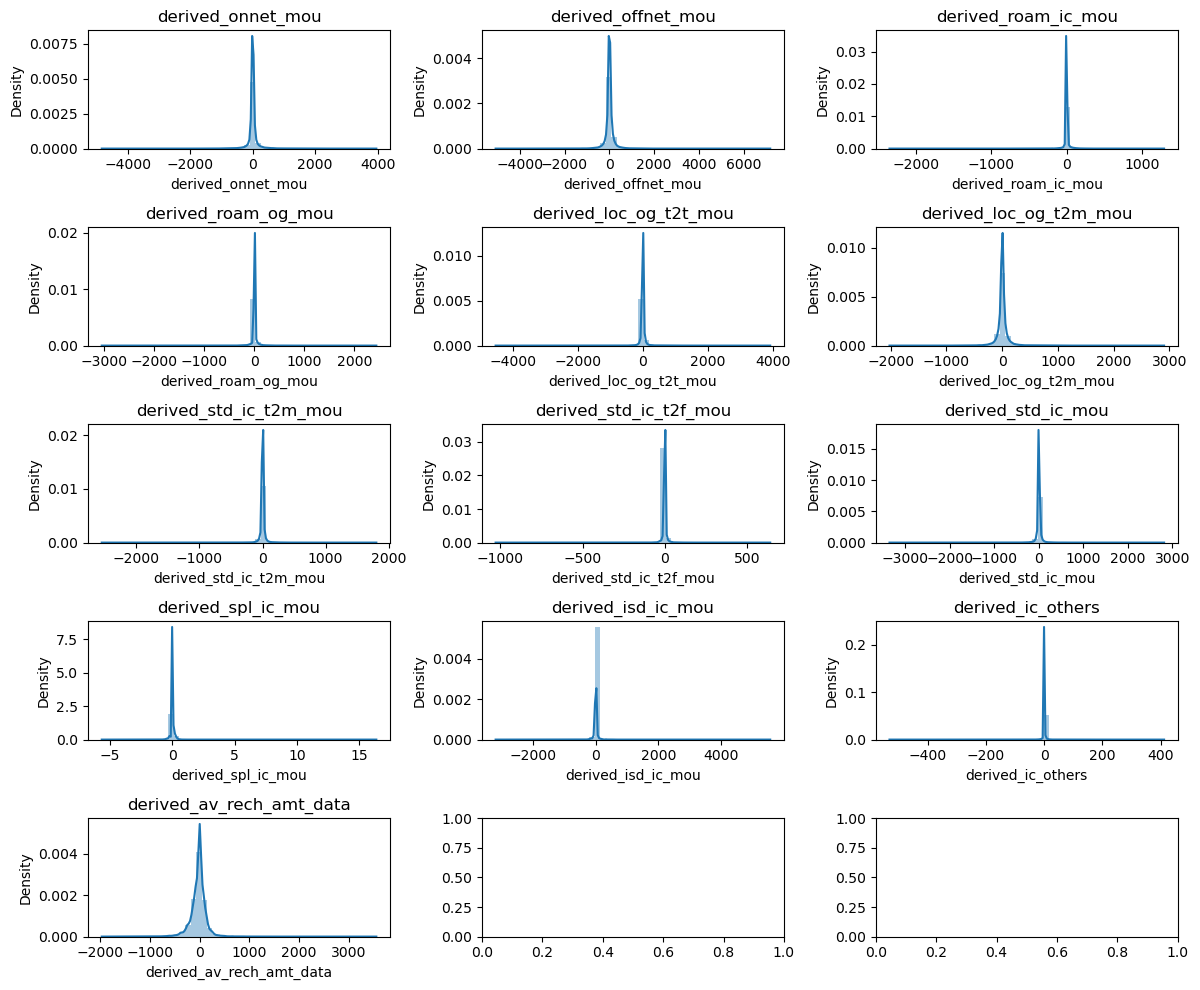

In [385]:
feature_list = ['derived_onnet_mou','derived_offnet_mou','derived_roam_ic_mou','derived_roam_og_mou','derived_loc_og_t2t_mou',
                'derived_loc_og_t2m_mou','derived_std_ic_t2m_mou','derived_std_ic_t2f_mou','derived_std_ic_mou',
                'derived_spl_ic_mou','derived_isd_ic_mou','derived_ic_others','derived_av_rech_amt_data']
generate_distribution_plot(feature_list)

Since most of the features are observed to be highly skewed, imputing the 'mode' value in place of missing data.

In [386]:
for feat in missing_values:
    High_value_customers[feat] = High_value_customers[feat].fillna(High_value_customers[feat].mode()[0])

In [387]:
# Verifying the features after Missing value Imputation
High_value_customers[missing_values].isnull().sum()

derived_onnet_mou           0
derived_offnet_mou          0
derived_roam_ic_mou         0
derived_roam_og_mou         0
derived_loc_og_t2t_mou      0
derived_loc_og_t2m_mou      0
derived_loc_og_t2f_mou      0
derived_loc_og_t2c_mou      0
derived_loc_og_mou          0
derived_std_og_t2t_mou      0
derived_std_og_t2m_mou      0
derived_std_og_t2f_mou      0
derived_std_og_mou          0
derived_isd_og_mou          0
derived_spl_og_mou          0
derived_og_others           0
derived_loc_ic_t2t_mou      0
derived_loc_ic_t2m_mou      0
derived_loc_ic_t2f_mou      0
derived_loc_ic_mou          0
derived_std_ic_t2t_mou      0
derived_std_ic_t2m_mou      0
derived_std_ic_t2f_mou      0
derived_std_ic_mou          0
derived_spl_ic_mou          0
derived_isd_ic_mou          0
derived_ic_others           0
derived_av_rech_amt_data    0
dtype: int64

## Outlier Treatment

In [388]:
len(High_value_customers.columns)

46

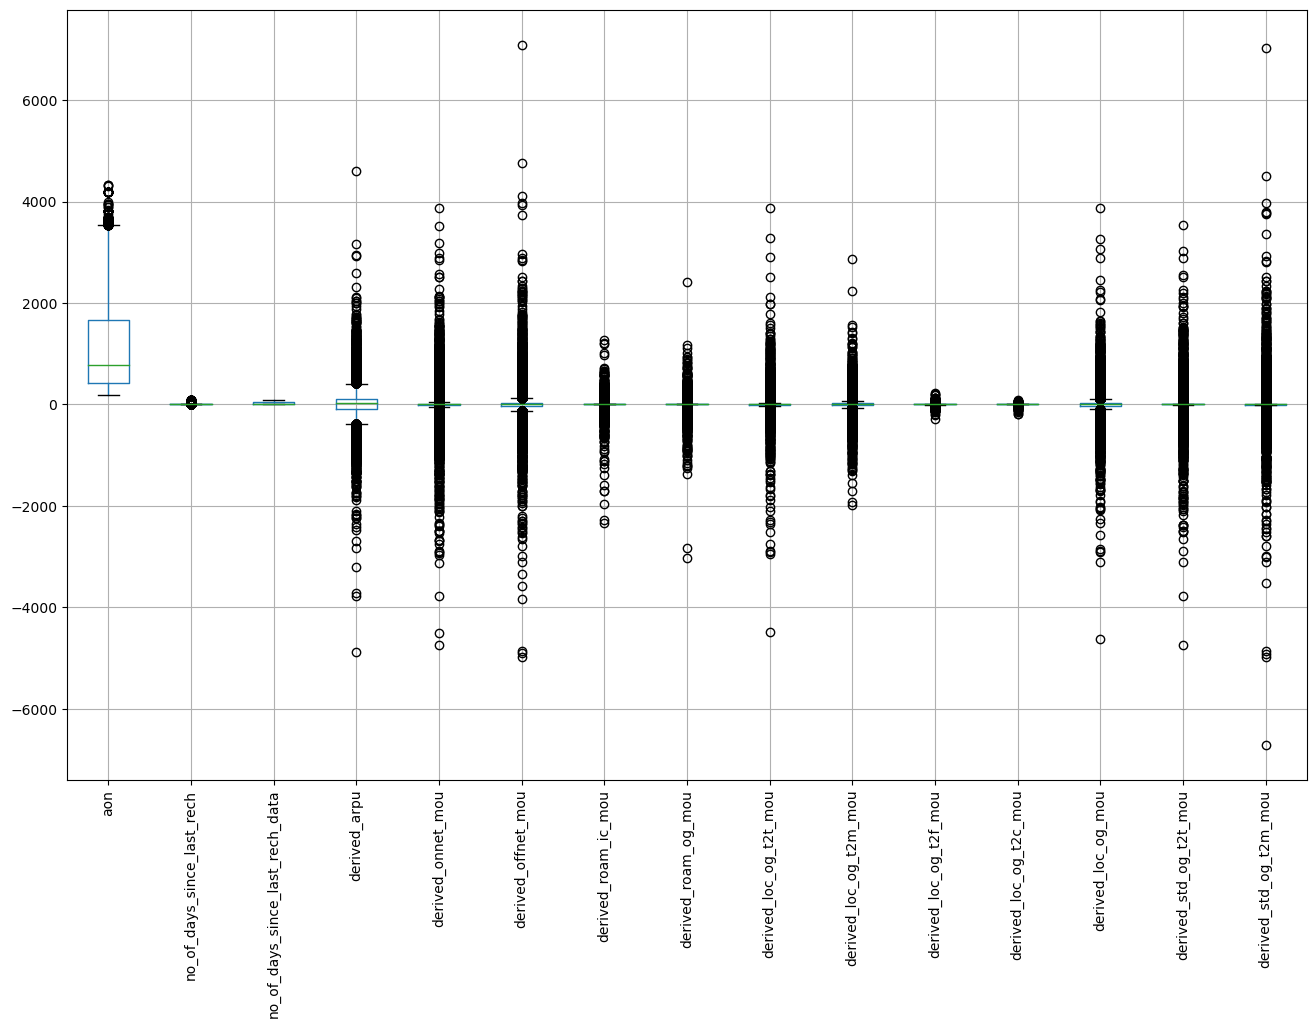

In [389]:
plt.figure(figsize = (16,10)) 
High_value_customers.iloc[:,:15].boxplot()
plt.xticks(rotation=90)
plt.show()

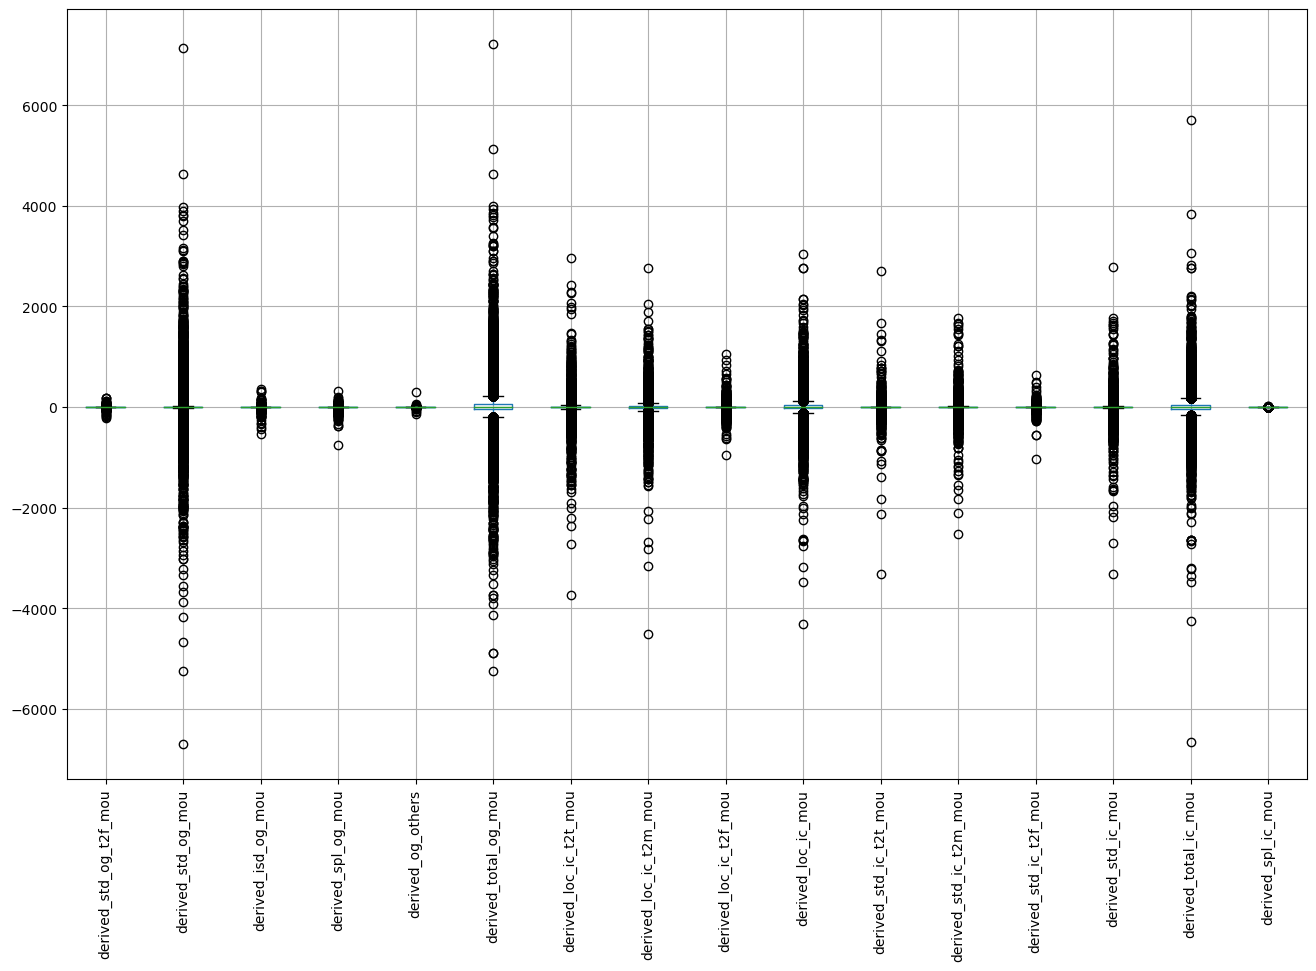

In [390]:
plt.figure(figsize = (16,10)) 
High_value_customers.iloc[:,15:31].boxplot()
plt.xticks(rotation=90)
plt.show()

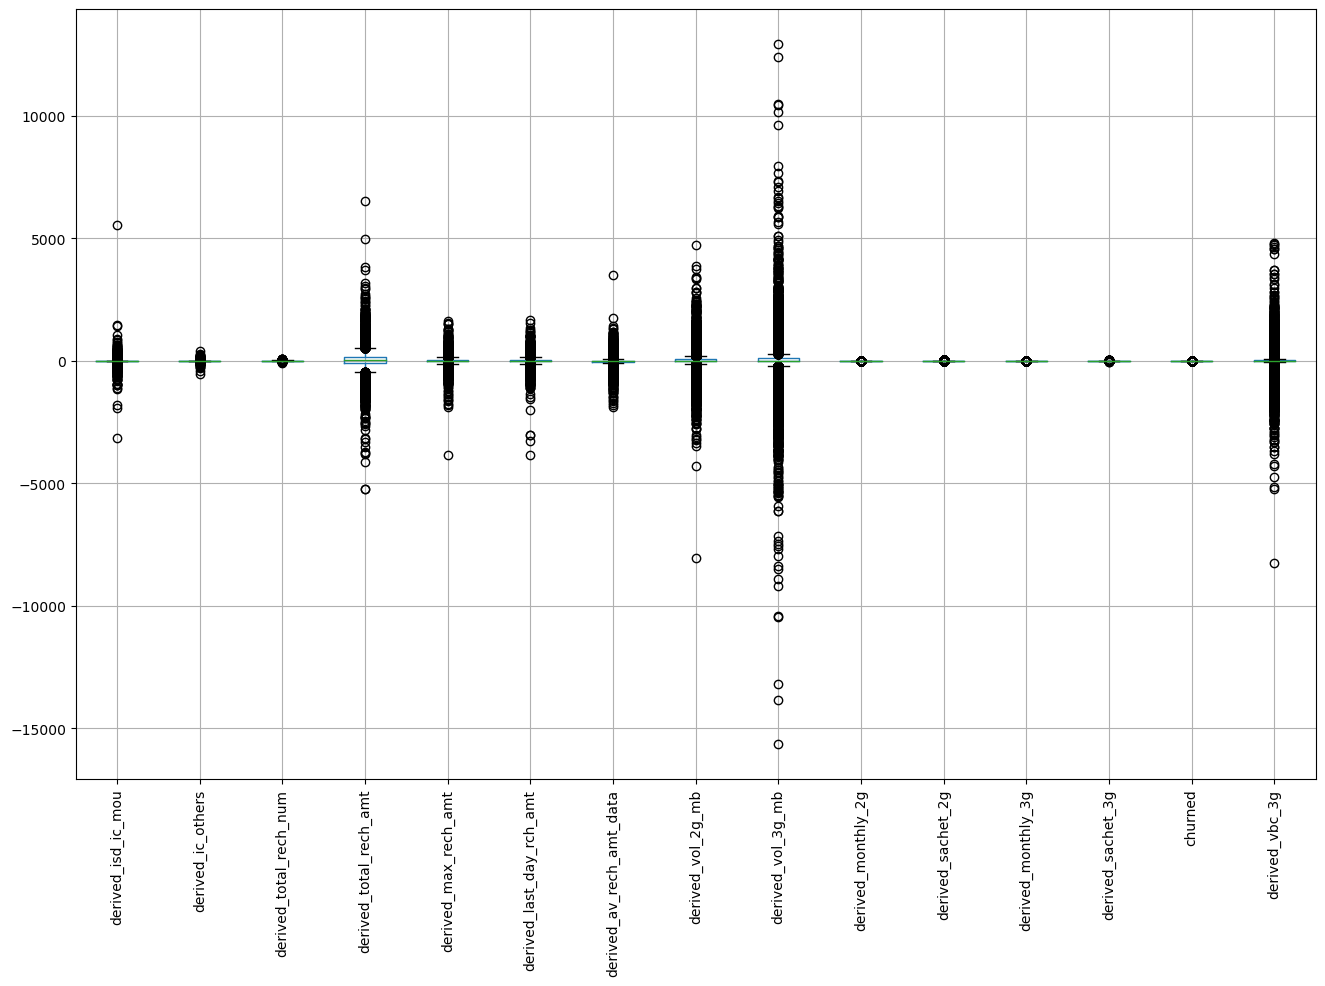

In [391]:
plt.figure(figsize = (16,10)) 
High_value_customers.iloc[:,31:].boxplot()
plt.xticks(rotation=90)
plt.show()

Since most of the features have a high number of outliers, dropping them would result in the loss of valuable information. Therefore, capping and flooring the extreme values is preferable.

In [392]:
for x in High_value_customers.drop(['churned'],axis=1).columns: # Excluding target column ie churned
    Q1 = High_value_customers[x].quantile(0.25)
    Q3 = High_value_customers[x].quantile(0.75)
    IQR = Q3 - Q1
    High_value_customers[x].loc[(High_value_customers[x] < (Q1 - 1.5 * IQR))]= Q1 - 1.5 * IQR
    High_value_customers[x].loc[(High_value_customers[x] > (Q3 + 1.5 * IQR))]= Q3 + 1.5 * IQR

## Checking Correlation

In [393]:
first_half = High_value_customers.columns[:23]
first_half = first_half.append(High_value_customers.columns[-2:-1]) # including 'churned column'
first_half

Index(['aon', 'no_of_days_since_last_rech', 'no_of_days_since_last_rech_data',
       'derived_arpu', 'derived_onnet_mou', 'derived_offnet_mou',
       'derived_roam_ic_mou', 'derived_roam_og_mou', 'derived_loc_og_t2t_mou',
       'derived_loc_og_t2m_mou', 'derived_loc_og_t2f_mou',
       'derived_loc_og_t2c_mou', 'derived_loc_og_mou',
       'derived_std_og_t2t_mou', 'derived_std_og_t2m_mou',
       'derived_std_og_t2f_mou', 'derived_std_og_mou', 'derived_isd_og_mou',
       'derived_spl_og_mou', 'derived_og_others', 'derived_total_og_mou',
       'derived_loc_ic_t2t_mou', 'derived_loc_ic_t2m_mou', 'churned'],
      dtype='object')

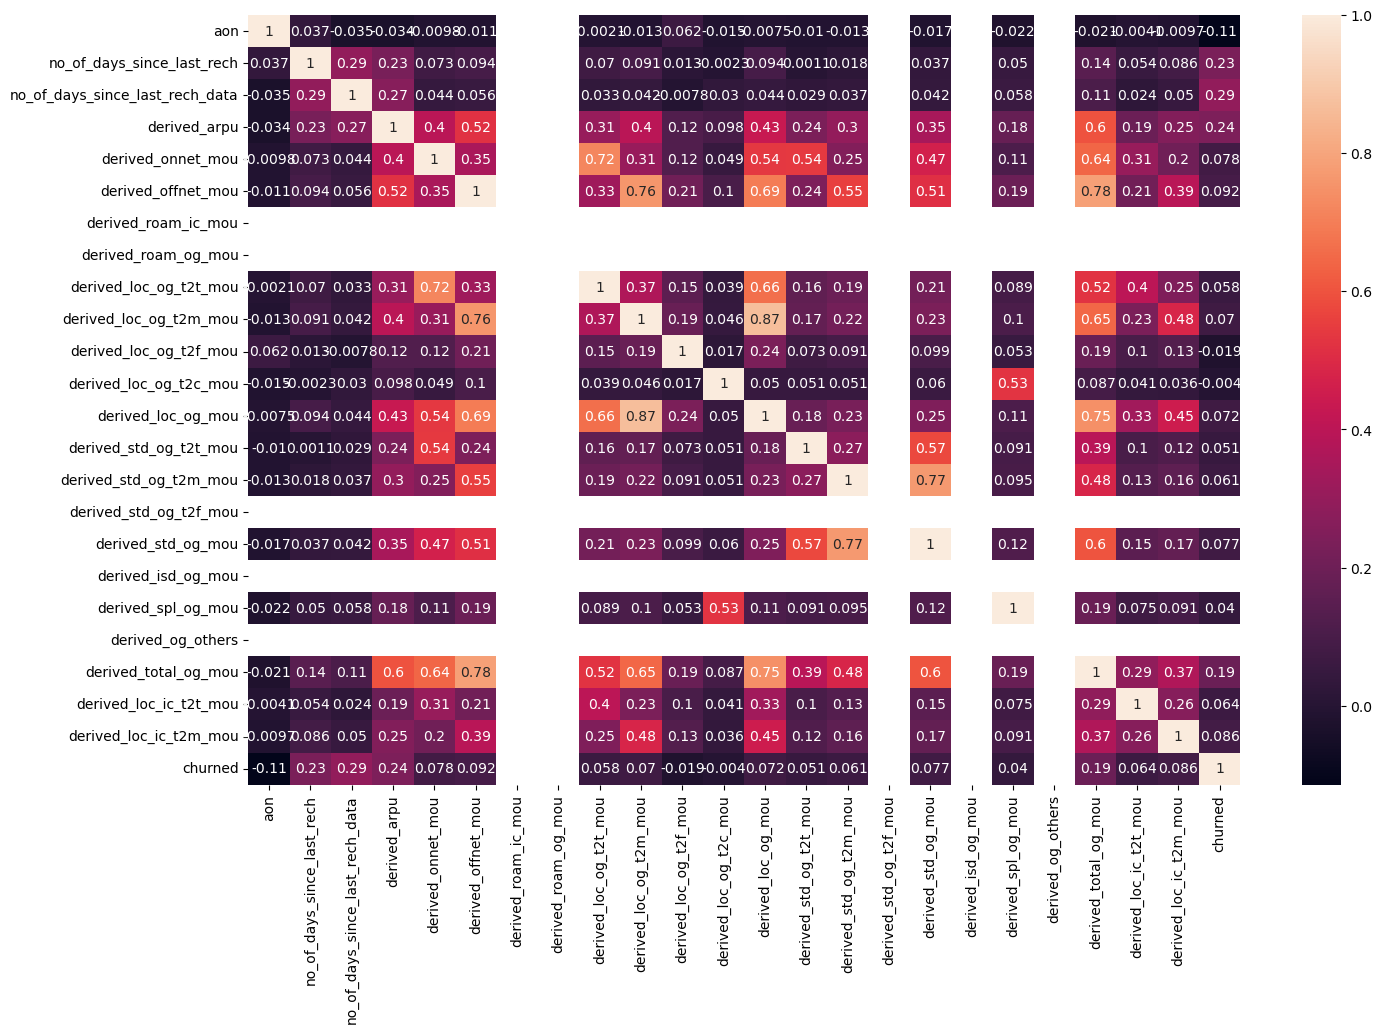

In [394]:
# Plotting correlation between first 23 features and 'churned'

plt.figure(figsize = (16,10))
sns.heatmap(High_value_customers[first_half].corr(),annot = True)
plt.show()

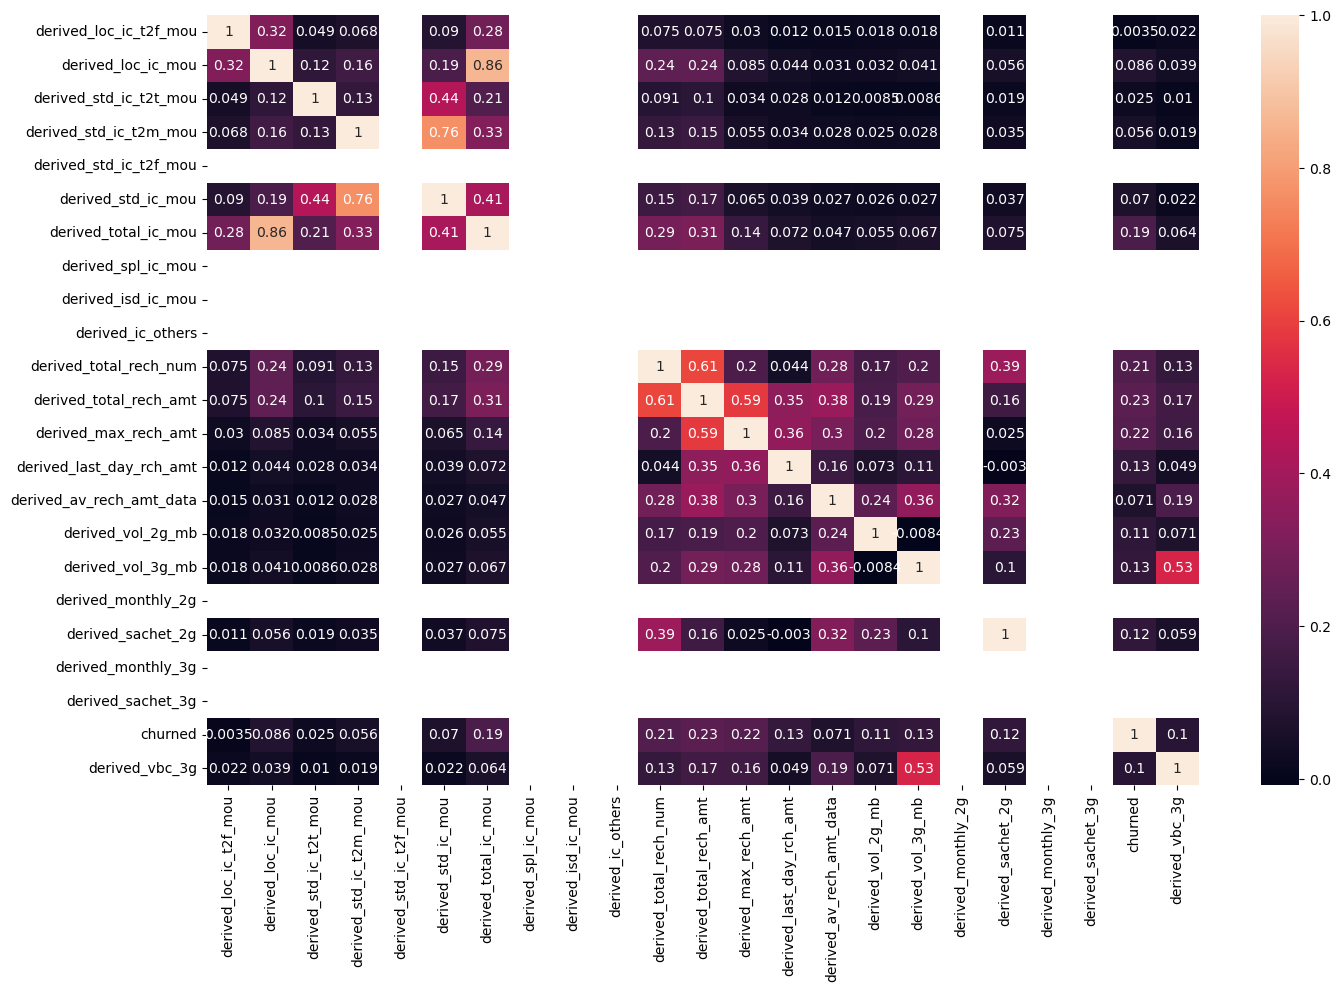

In [395]:
# Plotting correlation between remaining features and 'churned'

plt.figure(figsize = (16,10))
sns.heatmap(High_value_customers.iloc[:,23:].corr(),annot = True)
plt.show()

In [397]:
# After outlier treatment, some features have no variance.
# Identifying features with fixed values in all rows and removing them.
skewed = []
for column in High_value_customers.columns:
    if High_value_customers[column].nunique() == 1:
        skewed.append(column)
        print(High_value_customers[column].value_counts())
print("\n\n",skewed)

0.0    30378
Name: derived_roam_ic_mou, dtype: int64
0.0    30378
Name: derived_roam_og_mou, dtype: int64
0.0    30378
Name: derived_std_og_t2f_mou, dtype: int64
0.0    30378
Name: derived_isd_og_mou, dtype: int64
0.0    30378
Name: derived_og_others, dtype: int64
0.0    30378
Name: derived_std_ic_t2f_mou, dtype: int64
0.0    30378
Name: derived_spl_ic_mou, dtype: int64
0.0    30378
Name: derived_isd_ic_mou, dtype: int64
0.0    30378
Name: derived_ic_others, dtype: int64
0.0    30378
Name: derived_monthly_2g, dtype: int64
0.0    30378
Name: derived_monthly_3g, dtype: int64
0.0    30378
Name: derived_sachet_3g, dtype: int64


 ['derived_roam_ic_mou', 'derived_roam_og_mou', 'derived_std_og_t2f_mou', 'derived_isd_og_mou', 'derived_og_others', 'derived_std_ic_t2f_mou', 'derived_spl_ic_mou', 'derived_isd_ic_mou', 'derived_ic_others', 'derived_monthly_2g', 'derived_monthly_3g', 'derived_sachet_3g']


In [398]:
High_value_customers.drop(skewed,axis=1,inplace=True)

## Bivariate and Multivariate Analysis

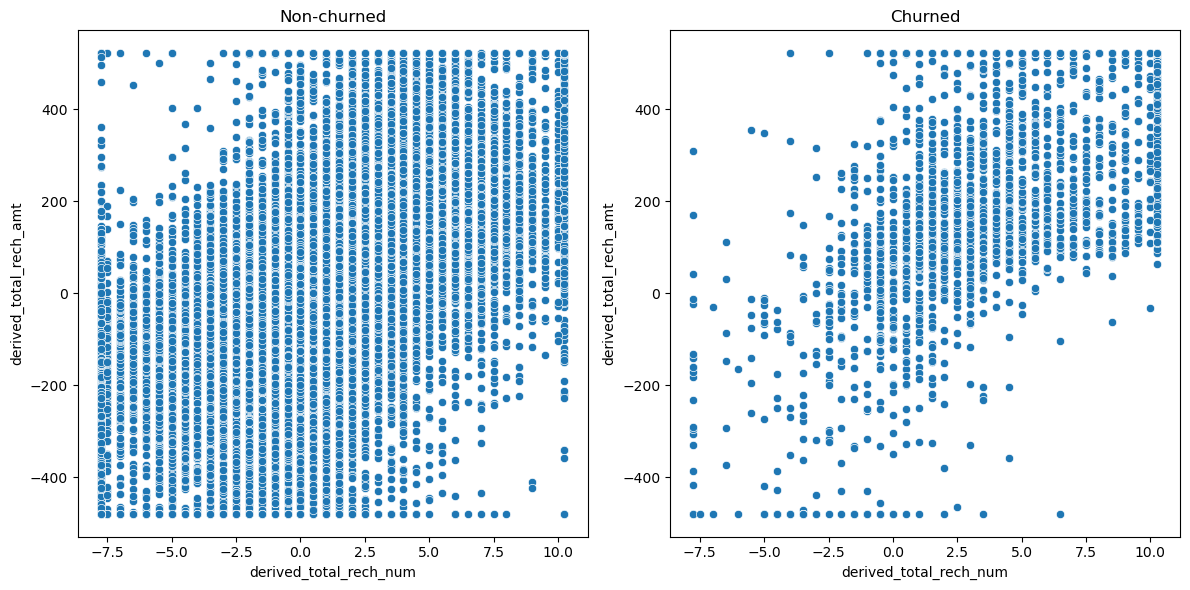

In [399]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Non-churned")
ax2.set_title("Churned")

sns.scatterplot(
    x=High_value_customers.loc[High_value_customers["churned"] == 0, 'derived_total_rech_num'], 
    y=High_value_customers.loc[High_value_customers["churned"] == 0, 'derived_total_rech_amt'], 
    ax=ax1
)
sns.scatterplot(
    x=High_value_customers.loc[High_value_customers["churned"] == 1, 'derived_total_rech_num'], 
    y=High_value_customers.loc[High_value_customers["churned"] == 1, 'derived_total_rech_amt'], 
    ax=ax2
)
plt.tight_layout()
plt.show()

**Observation:**

- There is a positive correlation between the total recharge amount and the total number of recharges.
- 'derived_total_rech_amt' is derived by taking the average of the total recharge done in the good phase (i.e., months 6 and 7) and deducting the recharge of the action phase (month 8) from it.
- A positive value of this feature means the recharge amount value dropped from the good phase to the action phase. The same applies to 'derived_total_rech_num' as well.
- A negative value of this feature means the recharge amount value increased from the good phase to the action phase. The same applies to 'derived_total_rech_num' as well.
- By comparing churned and non-churned customers, we can see that for churned customers, both recharge number and recharge amount have dropped in the action phase.


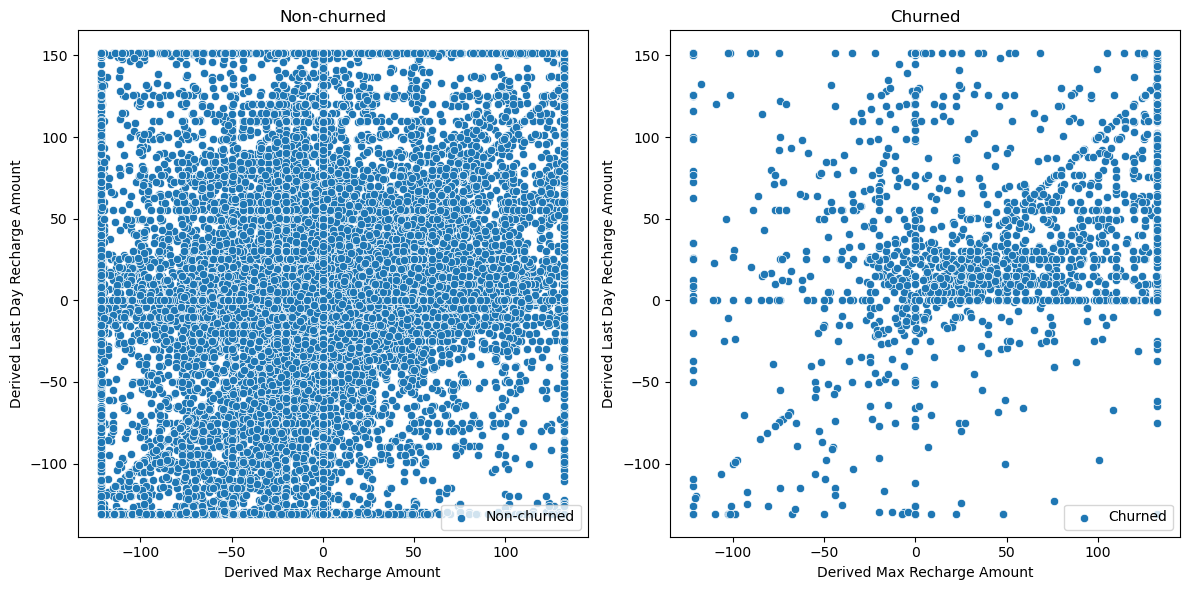

In [400]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")

sns.scatterplot(
    x=High_value_customers[High_value_customers["churned"] == 0]['derived_max_rech_amt'], 
    y=High_value_customers[High_value_customers["churned"] == 0]['derived_last_day_rch_amt'], 
    ax=ax1,
    label='Non-churned'
)
sns.scatterplot(
    x=High_value_customers[High_value_customers["churned"] == 1]['derived_max_rech_amt'], 
    y=High_value_customers[High_value_customers["churned"] == 1]['derived_last_day_rch_amt'], 
    ax=ax2,
    label='Churned'
)
ax1.set_xlabel('Derived Max Recharge Amount')
ax1.set_ylabel('Derived Last Day Recharge Amount')
ax2.set_xlabel('Derived Max Recharge Amount')
ax2.set_ylabel('Derived Last Day Recharge Amount')

plt.tight_layout()
plt.legend()
plt.show()

**Observation:**

'derived_max_rech_amt' and 'derived_last_day_rch_amt' are most likely to be positive for churned customers. This implies that a drop in the maximum recharge amount and last day recharge amount during the action phase can signify customer churn.

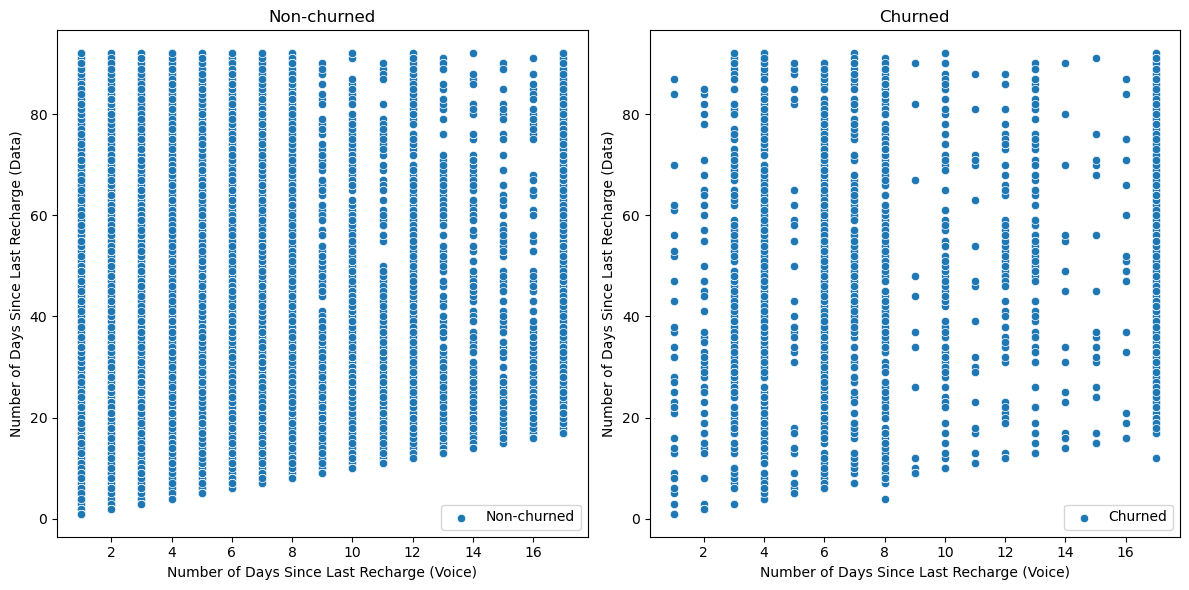

In [401]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")

sns.scatterplot(
    x=High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech'], 
    y=High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech_data'], 
    ax=ax1,
    label='Non-churned'
)
sns.scatterplot(
    x=High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech'], 
    y=High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech_data'], 
    ax=ax2,
    label='Churned'
)

ax1.set_xlabel('Number of Days Since Last Recharge (Voice)')
ax1.set_ylabel('Number of Days Since Last Recharge (Data)')
ax2.set_xlabel('Number of Days Since Last Recharge (Voice)')
ax2.set_ylabel('Number of Days Since Last Recharge (Data)')

plt.tight_layout()
plt.legend()
plt.show()

In [402]:
print("Non-churned Customers")
print(High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech'].value_counts(normalize=True))

print("Churned Customers")
print(High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech'].value_counts(normalize=True))


Non-churned Customers
1.0     0.163461
2.0     0.136169
3.0     0.108842
4.0     0.104743
6.0     0.091726
17.0    0.081479
7.0     0.074323
5.0     0.064111
8.0     0.063680
12.0    0.019129
10.0    0.019093
9.0     0.018554
11.0    0.014491
13.0    0.014059
14.0    0.010535
15.0    0.007911
16.0    0.007695
Name: no_of_days_since_last_rech, dtype: float64
Churned Customers
17.0    0.316712
6.0     0.156213
4.0     0.104012
8.0     0.082587
7.0     0.073627
3.0     0.068952
13.0    0.037398
10.0    0.034671
12.0    0.025711
2.0     0.022984
1.0     0.021815
5.0     0.016362
11.0    0.009349
16.0    0.008570
15.0    0.007402
9.0     0.007012
14.0    0.006623
Name: no_of_days_since_last_rech, dtype: float64


**Observation:**

- These two newly created features, 'days_since_last_recharge_jun_aug' and 'days_since_last_recharge_jul_aug', capture the number of days between the last recharge date available in June, July, or August and September 1st of the same year.

- When comparing churned and non-churned customers, we see a significant difference in their recent recharge behavior. Approximately 32% of churned customers had their last recharge 17 days prior to the reference date (September 1st). In contrast, only 8% of non-churned customers had their last recharge 17 days before the reference date.

- We can expect the number of days since last recharge to be generally lower for non-churned customers, indicating more frequent recharges.

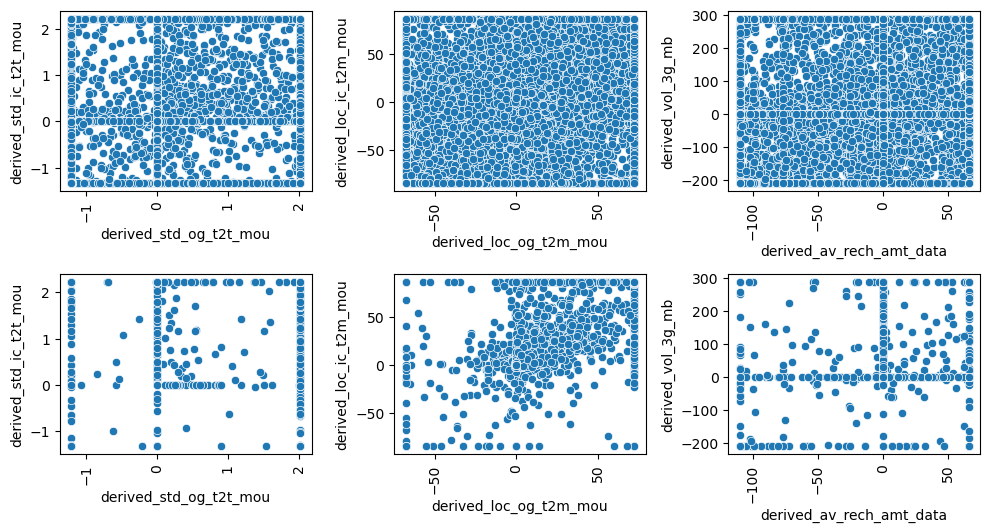

In [404]:
# Compare the correlation between the duration of STD and local calls for churned and non-churned customers
# Investigate trends in recharge amounts specifically for churned customers. 
feature_pair = [['derived_std_og_t2t_mou','derived_std_ic_t2t_mou'], ['derived_loc_og_t2m_mou', 'derived_loc_ic_t2m_mou'], ['derived_av_rech_amt_data','derived_vol_3g_mb']]

fig=plt.subplots(figsize=(10, 10))

for i, feats in enumerate(feature_pair+feature_pair):
    if i < 3:
        churned=0 # first row for non-churned
    else:
        churned=1 # second row for churned
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.scatterplot(x=High_value_customers[High_value_customers["churned"] == churned][feats[0]], y=High_value_customers[High_value_customers["churned"] == churned][feats[1]])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observation:**

We cannot observe a clear trend in call duration (STD and local) or recharge amounts when comparing churned and non-churned customers. This suggests that these features alone may not be strong indicators of customer churn.

## Splitting Data into Training and Test set

In [405]:
X = High_value_customers.drop(['churned'], axis=1)
y = High_value_customers[['churned']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [406]:
High_value_customers.shape

(30378, 34)

In [407]:
print("shape of X_train ", X_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_train ", y_train.shape)
print("shape of y_test ", y_test.shape)

shape of X_train  (21264, 33)
shape of X_test  (9114, 33)
shape of y_train  (21264, 1)
shape of y_test  (9114, 1)


## Feature Scaling

In [408]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Data Imbalance Treatment

In [409]:
print("Before Data Imbalance Treatment: ")
print("X train scaled shape : ", X_train_scaled.shape)
print("y train shape : ", y_train.shape)

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("After Data Imbalance Treatment: ")
print("X train shape : ", X_train_smote.shape)
print("y train shape : ", y_train_smote.shape)


Before Data Imbalance Treatment: 
X train scaled shape :  (21264, 33)
y train shape :  (21264, 1)
After Data Imbalance Treatment: 
X train shape :  (38832, 33)
y train shape :  (38832, 1)


For building the predictor model (where predicting churn is more important than model interpretability), the dimensionality reduction technique PCA will be applied to the independent variables. To identify the most significant driving factors of churn, X_train_scaled will be used.

# Applying PCA and Building Predictor Model

In [410]:
def evaluate_model(y_true, y_pred):
    confusion = metrics.confusion_matrix(y_true, y_pred)
    TP = confusion[1,1] 
    TN = confusion[0,0] 
    FP = confusion[0,1] 
    FN = confusion[1,0] 

    accuracy_sc = metrics.accuracy_score(y_true, y_pred)
    sensitivity_score = TP / float(TP+FN)
    return accuracy_sc, sensitivity_score

## Logistic Regression

Using the Logistic Regression Model as the base model:

- Performing PCA for component numbers 10, 15, 20, 25, 30.
- Performing Logistic Regression with different numbers of features and different cutoff values: 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8.
- Storing the accuracy score and sensitivity scores of the models on the test data in two different dataframes.
- This will help in finding out the optimum number of features (for PCA) and the cutoff value (for Logistic Regression).

In [412]:
accuracy_test_data = pd.DataFrame(data=np.zeros((7,5)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[10,15,20,25,30])
sensitivity_test_data = pd.DataFrame(data=np.zeros((7,5)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[10,15,20,25,30])

for n in [10,15,20,25,30]:
    pca = IncrementalPCA(n_components=n)    
    X_train_pca = pca.fit_transform(X_train_smote) # training data is scaled and treated for data imbalance
    X_test_pca = pca.transform(X_test_scaled)      # test data is only scaled
      
    X_train_sm = sm.add_constant(X_train_pca)
    X_test_sm = sm.add_constant(X_test_pca)
    logm2 = sm.GLM(y_train_smote,X_train_sm, family = sm.families.Binomial())
    res = logm2.fit()

    #y_train_pred = res.predict(X_train_sm)
    y_test_pred = res.predict(X_test_sm)

    df = pd.DataFrame()
    df['true_value'] = y_test.values.reshape(-1)
    df['pred_prob_value'] = y_test_pred.reshape(-1) # predicted probability of churned

    for cutoff in [float(x)/10 for x in range(2, 9)]:
        col_name = 'pred_value' + str(cutoff)
        df[col_name] = df['pred_prob_value'].map(lambda x: 1 if x > cutoff else 0)
        accuracy_test_data.loc[cutoff, n], sensitivity_test_data.loc[cutoff, n] = evaluate_model(y_test, df[col_name])

In [413]:
df.head(5)

,true_value,pred_prob_value,pred_value0.2,pred_value0.3,pred_value0.4,pred_value0.5,pred_value0.6,pred_value0.7,pred_value0.8
0,0,0.619395,1,1,1,1,1,0,0
1,0,0.183447,0,0,0,0,0,0,0
2,1,0.907873,1,1,1,1,1,1,1
3,0,0.078319,0,0,0,0,0,0,0
4,0,0.229467,1,0,0,0,0,0,0


In [414]:
sensitivity_test_data

,10,15,20,25,30
0.2,0.930459,0.938804,0.927677,0.934631,0.936022
0.3,0.885953,0.891516,0.887344,0.892907,0.891516
0.4,0.842837,0.834492,0.840056,0.845619,0.835883
0.5,0.789986,0.781641,0.777469,0.773296,0.774687
0.6,0.712100,0.732962,0.728790,0.714882,0.713491
0.7,0.625869,0.648122,0.639777,0.645341,0.636996
0.8,0.479833,0.511822,0.521558,0.534075,0.538248


In [415]:
accuracy_test_data

,10,15,20,25,30
0.2,0.473996,0.522273,0.526991,0.531051,0.528966
0.3,0.596884,0.639675,0.640334,0.646149,0.648343
0.4,0.693110,0.722405,0.723063,0.730086,0.731622
0.5,0.766952,0.783849,0.788348,0.791200,0.794163
0.6,0.827738,0.835308,0.837722,0.841453,0.840355
0.7,0.878758,0.876893,0.878429,0.880843,0.880733
0.8,0.914637,0.908163,0.908492,0.912113,0.914417


After inspecting the accuracy score and sensitivity score for different numbers of principal components and cutoff values, we determine that using 15 components and a cutoff of 0.5 yields optimal results.

In [416]:
pca = IncrementalPCA(n_components=15)    
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_scaled)

In [417]:
evaluation_df = pd.DataFrame(data=np.zeros((4,2)), index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'], columns=['Accuracy', 'Sensitivity'])
evaluation_df.loc['Logistic Regression', 'Accuracy'] = round(accuracy_test_data.loc[0.5, 15], 3)
evaluation_df.loc['Logistic Regression', 'Sensitivity'] = round(sensitivity_test_data.loc[0.5, 15],3)
evaluation_df

,Accuracy,Sensitivity
Logistic Regression,0.784,0.782
Decision Tree,0.000,0.000
Random Forest,0.000,0.000
XGBoost,0.000,0.000


- Given that the primary objective is to identify as many potential instances of churn as possible, we will prioritize sensitivity for evaluating the model.

- We will use GridSearchCV to fine-tune the hyperparameters and obtain the best estimator.

## Decision Tree

In [418]:
dt = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "recall")
grid_search.fit(X_train_pca, y_train_smote)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'min_samples_leaf': [5, 20, 50, 100]},
             scoring='recall', verbose=1)

In [419]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}

In [420]:
dt_best = grid_search.best_estimator_
dt_best.fit(X_train_pca, y_train_smote)
y_train_pred_dt = dt_best.predict(X_train_pca)
y_test_pred_dt = dt_best.predict(X_test_pca)
print(y_test_pred_dt)

[0 0 1 ... 0 0 0]


In [421]:
print("Performance of Decision Tree Classifier on training data")
accuracy_sc, sensitivity_score = evaluate_model(y_train_smote, y_train_pred_dt)
print("Accuracy : ", accuracy_sc)
print("Sensitivity : ", sensitivity_score)

print("Performance of Decision Tree Classifier on test data")
accuracy_sc, sensitivity_score = evaluate_model(y_test, y_test_pred_dt)
evaluation_df.loc['Decision Tree', 'Accuracy'] = accuracy_sc
evaluation_df.loc['Decision Tree', 'Sensitivity'] = sensitivity_score
evaluation_df

Performance of Decision Tree Classifier on training data
Accuracy :  0.9473114956736712
Sensitivity :  0.9648228265348167
Performance of Decision Tree Classifier on test data


,Accuracy,Sensitivity
Logistic Regression,0.784000,0.782000
Decision Tree,0.847597,0.684284
Random Forest,0.000000,0.000000
XGBoost,0.000000,0.000000


## Random Forest

In [423]:
%timeit
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 20, 50],
    'max_features': [3, 4, 5],
    'n_estimators': [50, 100]
}

grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=3, n_jobs=-1, verbose=1, scoring = "recall")

grid_search.fit(X_train_pca,y_train_smote)
rf_best = grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [424]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [425]:
rf_best.fit(X_train_pca, y_train_smote)
y_train_pred_rf = rf_best.predict(X_train_pca)
y_test_pred_rf = rf_best.predict(X_test_pca)
print(y_test_pred_rf)

[0 0 0 ... 0 0 0]


In [426]:
print("Performance of Random Forest Classifier on training data")
accuracy_sc, sensitivity_score = evaluate_model(y_train_smote, y_train_pred_rf)
print("Accuracy : ", accuracy_sc)
print("Sensitivity : ", sensitivity_score)

print("Performance of Random Forest Classifier on test data")
accuracy_sc,sensitivity_score = evaluate_model(y_test, y_test_pred_rf)
evaluation_df.loc['Random Forest', 'Accuracy'] = round(accuracy_sc, 5)
evaluation_df.loc['Random Forest', 'Sensitivity'] = round(sensitivity_score, 5)
evaluation_df

Performance of Random Forest Classifier on training data
Accuracy :  0.9686083642356819
Sensitivity :  0.9881025957972805
Performance of Random Forest Classifier on test data


,Accuracy,Sensitivity
Logistic Regression,0.784000,0.782000
Decision Tree,0.847597,0.684284
Random Forest,0.898620,0.667590
XGBoost,0.000000,0.000000


- Random Forest achieves the best accuracy but may miss a significant portion of churned customers.
- Decision Tree offers a balance between accuracy and sensitivity.
- Logistic Regression has the lowest accuracy but highest sensitivity.

## XGBoost

In [428]:
%timeit
xgclf = xgb.XGBClassifier()

parameters = {'learning_rate': [0.2, 0.3, 0.4],
              'max_depth': [10, 20],
              'n_estimators': [100, 200, 500]}

clf_xgb = GridSearchCV(estimator=xgclf,
                      param_grid=parameters,
                      n_jobs=-1,
                      cv=3,
                      scoring='recall',
                      verbose=1,
                      refit=True)

clf_xgb.fit(X_train_pca, y_train_smote)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [10, 20],
                         'n_estimators': [100, 200, 500]},
             scoring='recall', verbose=1)

In [429]:
clf_xgb.best_params_

{'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 500}

In [430]:
xgb_best = clf_xgb.best_estimator_

xgb_best.fit(X_train_pca, y_train_smote)
y_train_pred_xgb = xgb_best.predict(X_train_pca)
y_test_pred_xgb = xgb_best.predict(X_test_pca)
print(y_test_pred_xgb)

[1 0 0 ... 0 0 0]


In [431]:
print("Performance of XGBoost Classifier on training data")
accuracy_sc, sensitivity_score = evaluate_model(y_train_smote, y_train_pred_xgb)
print("Accuracy : ", accuracy_sc)
print("Sensitivity : ", sensitivity_score)

print("Performance of XGBoost Classifier on test data")
accuracy_sc, sensitivity_score = evaluate_model(y_test, y_test_pred_xgb)
evaluation_df.loc['XGBoost', 'Accuracy'] = round(accuracy_sc, 5)
evaluation_df.loc['XGBoost', 'Sensitivity'] = round(sensitivity_score, 5)
evaluation_df

Performance of XGBoost Classifier on training data
Accuracy :  1.0
Sensitivity :  1.0
Performance of XGBoost Classifier on test data


,Accuracy,Sensitivity
Logistic Regression,0.784000,0.782000
Decision Tree,0.847597,0.684284
Random Forest,0.898620,0.667590
XGBoost,0.908710,0.595270


After comparing the accuracy and sensitivity scores on the test data of different models like Logistic Regression, Decision Tree Classifier, Random Forest Classifier, and XGBoost, it is observed that:

- **Logistic Regression has the highest sensitivity score and the lowest accuracy score.**

- In this particular scenario, it is important to predict as much potential churn as possible to formulate effective business strategies to reduce churn. Hence, sensitivity is considered over accuracy and other evaluation metrics.

- The Logistic Regression model with a cutoff of 0.5 and 15 principal components has achieved a sensitivity of 0.78 on the test data, meaning it is able to predict 78% of the total churned cases in unseen data.

## Building Final Predictor Model

In [435]:
# Optimizing Logistic Regression Model further
# Calculating accuracy and sensitivity for  probability cutoffs [0.25, 0.26, 0.27, ... , 0.5]

performance_df = pd.DataFrame(columns = ['proba_score','accuracy_score','sensitivity_score'])
pca = IncrementalPCA(n_components=15)    
X_train_pca = pca.fit_transform(X_train_smote) # training data is scaled and treated for data imbalance
X_test_pca = pca.transform(X_test_scaled)      # test data is only scaled

# Training Logistic Regression Model for getting Churn Probability
X_train_sm = sm.add_constant(X_train_pca)
X_test_sm = sm.add_constant(X_test_pca)
logm2 = sm.GLM(y_train_smote,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()

#y_train_pred = res.predict(X_train_sm)
y_test_pred = res.predict(X_test_sm)

df = pd.DataFrame()
df['true_value'] = y_test.values.reshape(-1)      # churned value
df['pred_prob_value'] = y_test_pred.reshape(-1)   # predicted churned probability

# The predicted churned probability remain fixed as no change in training data and model hyperpameters.
# The predicted churned label (0 or 1) changes with change in cut-off

for cutoff in [float(x)/100 for x in range(35, 60)]:
    col_name = 'pred_value_' + str(cutoff)
    df[col_name] = df['pred_prob_value'].map(lambda x: 1 if x > cutoff else 0) # Predicted churned based on cutoff value
    performance_df.loc[cutoff, 'proba_score'] = cutoff
    performance_df.loc[cutoff, 'accuracy_score'], performance_df.loc[cutoff, 'sensitivity_score'] = evaluate_model(y_test, df[col_name])

In [436]:
df.head(5)

,true_value,pred_prob_value,pred_value_0.35,pred_value_0.36,pred_value_0.37,pred_value_0.38,pred_value_0.39,pred_value_0.4,pred_value_0.41,pred_value_0.42,pred_value_0.43,pred_value_0.44,pred_value_0.45,pred_value_0.46,pred_value_0.47,pred_value_0.48,pred_value_0.49,pred_value_0.5,pred_value_0.51,pred_value_0.52,pred_value_0.53,pred_value_0.54,pred_value_0.55,pred_value_0.56,pred_value_0.57,pred_value_0.58,pred_value_0.59
0,0,0.633355,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0.207490,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0.914089,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.098302,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.200545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [437]:
performance_df

,proba_score,accuracy_score,sensitivity_score
0.35,0.35,0.682357,0.860918
0.36,0.36,0.689818,0.858136
0.37,0.37,0.699364,0.852573
0.38,0.38,0.705837,0.845619
0.39,0.39,0.714505,0.838665
0.40,0.4,0.722405,0.834492
0.41,0.41,0.728769,0.824757
0.42,0.42,0.735023,0.819193
0.43,0.43,0.741277,0.81363
0.44,0.44,0.746873,0.810848


By inspecting performance metrics of logistric regression model for different cutoff values between 0.35 to 0.6, we are selecting 0.50 as the cutoff for final model as it has accuracy score of 0.78 and sensitivity score of 0.78


- **Final Predictor Model = Logistic Regression**
- **No. of principal = 15**
- **Probability Cutoff = 0.5**


# Feature Selection for Building Interpretable Model

- Starting with RFE to identify top 20 features first
- Then manually inspecting p-values and VIF to improvise the model further.
- Logistic Regression model has good interpretability, also Logistic Regression model performed better with respect to sensitivity.

### Using RFE for Identifying top 20 features

In [438]:
# X_train_scaled is scaled. However its a Numpy array.
# To retain the column names, creating a dataframe with columns of X and values of X_train_scaled 

X_tr_scaled_df = pd.DataFrame(data=X_train_scaled, columns= X.columns)

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=20)             
rfe = rfe.fit(X_tr_scaled_df, y_train)

print(list(zip(X_tr_scaled_df.columns, rfe.support_, rfe.ranking_)))

[('aon', True, 1), ('no_of_days_since_last_rech', True, 1), ('no_of_days_since_last_rech_data', True, 1), ('derived_arpu', True, 1), ('derived_onnet_mou', False, 3), ('derived_offnet_mou', True, 1), ('derived_loc_og_t2t_mou', False, 4), ('derived_loc_og_t2m_mou', True, 1), ('derived_loc_og_t2f_mou', True, 1), ('derived_loc_og_t2c_mou', True, 1), ('derived_loc_og_mou', True, 1), ('derived_std_og_t2t_mou', False, 9), ('derived_std_og_t2m_mou', False, 10), ('derived_std_og_mou', True, 1), ('derived_spl_og_mou', False, 14), ('derived_total_og_mou', True, 1), ('derived_loc_ic_t2t_mou', True, 1), ('derived_loc_ic_t2m_mou', True, 1), ('derived_loc_ic_t2f_mou', False, 8), ('derived_loc_ic_mou', True, 1), ('derived_std_ic_t2t_mou', False, 11), ('derived_std_ic_t2m_mou', False, 13), ('derived_std_ic_mou', False, 12), ('derived_total_ic_mou', True, 1), ('derived_total_rech_num', False, 6), ('derived_total_rech_amt', False, 7), ('derived_max_rech_amt', True, 1), ('derived_last_day_rch_amt', True, 

In [439]:
def build_lr_model(X, y):
    X = sm.add_constant(X)
    logm2 = sm.GLM(y, X, family = sm.families.Binomial())
    res = logm2.fit()
    print(res.summary())

def print_vif(X):
    vif = pd.DataFrame(data=X.columns, columns=['Features'])
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [440]:
top_20 = X_tr_scaled_df.columns[rfe.support_]
print("Derived Features Dropped by RFE : ", X_tr_scaled_df.columns[~rfe.support_])
print("============================================================")
build_lr_model(X_tr_scaled_df[top_20], y_train.values)
print_vif(X_tr_scaled_df[top_20])

Derived Features Dropped by RFE :  Index(['derived_onnet_mou', 'derived_loc_og_t2t_mou', 'derived_std_og_t2t_mou',
       'derived_std_og_t2m_mou', 'derived_spl_og_mou',
       'derived_loc_ic_t2f_mou', 'derived_std_ic_t2t_mou',
       'derived_std_ic_t2m_mou', 'derived_std_ic_mou',
       'derived_total_rech_num', 'derived_total_rech_amt', 'derived_vol_2g_mb',
       'derived_vol_3g_mb'],
      dtype='object')
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21243
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4379.7
Date:                Mon, 03 Jun 2024   Deviance:                       8759.4
Time:                        18:

In [441]:
# Dropping feature with highest VIF Value
top_19=top_20.drop('derived_loc_ic_mou')
build_lr_model(X_tr_scaled_df[top_19], y_train.values)
print_vif(X_tr_scaled_df[top_19])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21244
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4402.2
Date:                Mon, 03 Jun 2024   Deviance:                       8804.4
Time:                        18:55:58   Pearson chi2:                 2.57e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1619
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [442]:
# Dropping feature with highest VIF Value
top_18=top_19.drop('derived_total_og_mou')
build_lr_model(X_tr_scaled_df[top_18], y_train.values)
print_vif(X_tr_scaled_df[top_18])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21245
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4486.1
Date:                Mon, 03 Jun 2024   Deviance:                       8972.1
Time:                        18:56:34   Pearson chi2:                 2.47e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [443]:
# Dropping feature with p-value > 0.05
top_17=top_18.drop('derived_loc_og_mou')
build_lr_model(X_tr_scaled_df[top_17], y_train.values)
print_vif(X_tr_scaled_df[top_17])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21246
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4486.5
Date:                Mon, 03 Jun 2024   Deviance:                       8973.1
Time:                        18:58:52   Pearson chi2:                 2.47e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [444]:
# Dropping feature with highest p-value > 0.05
top_16=top_17.drop('derived_loc_og_t2m_mou')
build_lr_model(X_tr_scaled_df[top_16], y_train.values)
print_vif(X_tr_scaled_df[top_16])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21247
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4487.0
Date:                Mon, 03 Jun 2024   Deviance:                       8974.0
Time:                        18:59:35   Pearson chi2:                 2.47e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [445]:
# Removing feature with p-value > 0.5
top_15=top_16.drop('derived_std_og_mou')
build_lr_model(X_tr_scaled_df[top_15], y_train.values)
print_vif(X_tr_scaled_df[top_15])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21248
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4488.4
Date:                Mon, 03 Jun 2024   Deviance:                       8976.8
Time:                        19:00:38   Pearson chi2:                 2.49e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1551
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [446]:
# Removing feature with p-value > 0.5
top_14=top_15.drop('derived_offnet_mou')
build_lr_model(X_tr_scaled_df[top_14], y_train.values)
print_vif(X_tr_scaled_df[top_14])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21264
Model:                            GLM   Df Residuals:                    21249
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4489.9
Date:                Mon, 03 Jun 2024   Deviance:                       8979.7
Time:                        19:02:50   Pearson chi2:                 2.46e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1549
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

VIF and p-value of the remaining features are in acceptable range.

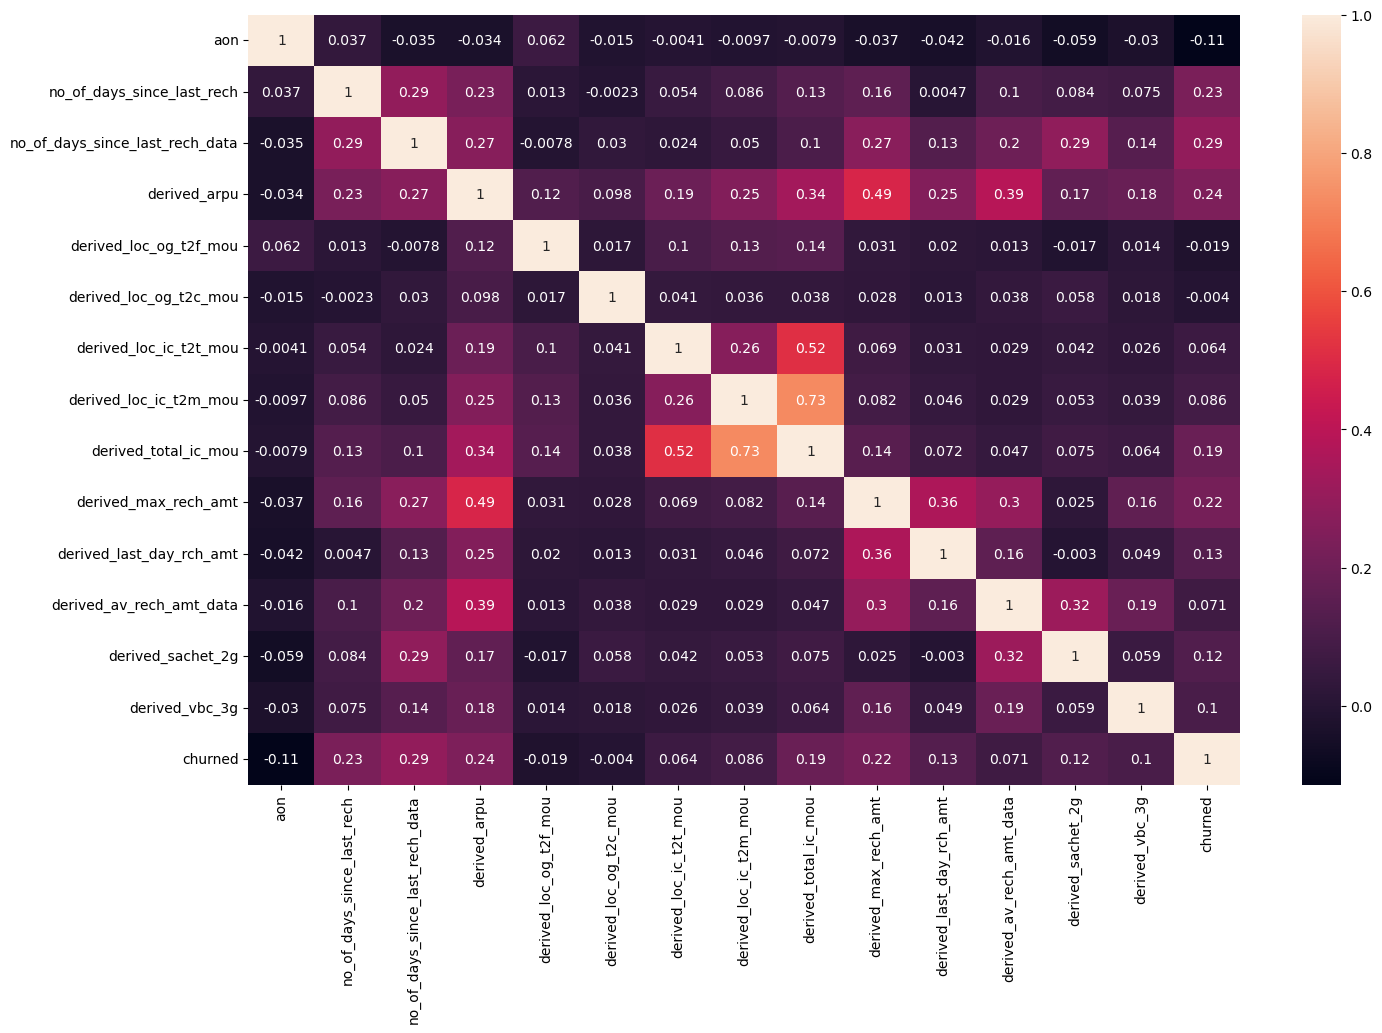

In [447]:
cols = top_14.append(High_value_customers.columns[-2:-1]) # adding churned column

plt.figure(figsize = (16,10))
sns.heatmap(High_value_customers[cols].corr(),annot = True)
plt.show()

### Using Random Forest for Feature Importance

In [448]:
rf_best = RandomForestClassifier(random_state=42, n_jobs=-1,max_depth=20,max_features=4,min_samples_leaf=5,n_estimators=100)

X_tr_smote_df = pd.DataFrame(data=X_train_smote, columns= X.columns)

rf_best.fit(X_tr_smote_df[top_14], y_train_smote)

RandomForestClassifier(max_depth=20, max_features=4, min_samples_leaf=5,
                       n_jobs=-1, random_state=42)

In [449]:
feature_importance_df = pd.DataFrame({
    "Feature Name": X_tr_smote_df[top_14].columns,
    "Importance": rf_best.feature_importances_})

feature_importance_df.sort_values(by="Importance", ascending=False)

,Feature Name,Importance
2,no_of_days_since_last_rech_data,0.165529
7,derived_loc_ic_t2m_mou,0.130302
1,no_of_days_since_last_rech,0.122632
9,derived_max_rech_amt,0.122381
3,derived_arpu,0.084093
6,derived_loc_ic_t2t_mou,0.077775
8,derived_total_ic_mou,0.062116
10,derived_last_day_rch_amt,0.049982
0,aon,0.042581
4,derived_loc_og_t2f_mou,0.040310


In [450]:
print("Top 14 features are : ", feature_importance_df['Feature Name'].values)

Top 14 features are :  ['aon' 'no_of_days_since_last_rech' 'no_of_days_since_last_rech_data'
 'derived_arpu' 'derived_loc_og_t2f_mou' 'derived_loc_og_t2c_mou'
 'derived_loc_ic_t2t_mou' 'derived_loc_ic_t2m_mou' 'derived_total_ic_mou'
 'derived_max_rech_amt' 'derived_last_day_rch_amt'
 'derived_av_rech_amt_data' 'derived_sachet_2g' 'derived_vbc_3g']


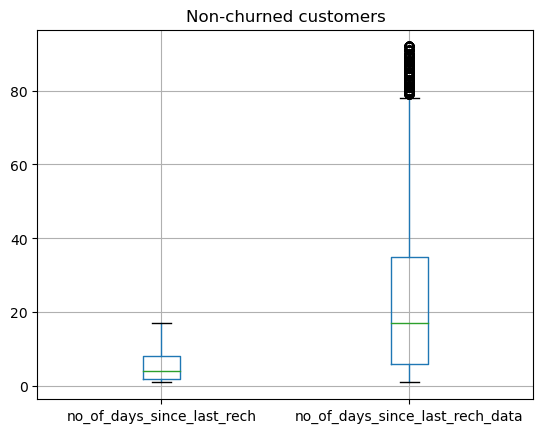

In [451]:
High_value_customers[High_value_customers['churned'] == 0][['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].boxplot()
plt.title("Non-churned customers")
plt.show()

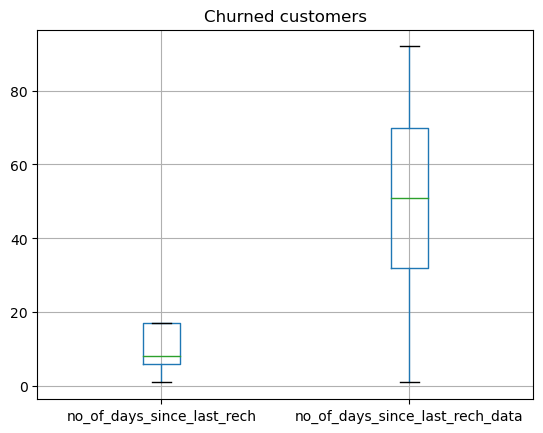

In [452]:
High_value_customers[High_value_customers['churned'] == 1][['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].boxplot()
plt.title("Churned customers")
plt.show()

In [453]:
print("75 percentile of no_of_days_since_last_rech for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1]['no_of_days_since_last_rech'].quantile(.75))

print("75 percentile of no_of_days_since_last_rech for non-Churned customers")
print(High_value_customers[High_value_customers['churned'] == 0]['no_of_days_since_last_rech'].quantile(.75))

print("50 percentile of no_of_days_since_last_rech_data for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1]['no_of_days_since_last_rech_data'].quantile(.50))

print("50 percentile of no_of_days_since_last_rech_data for non-Churned customers")
print(High_value_customers[High_value_customers['churned'] == 0]['no_of_days_since_last_rech_data'].quantile(.50))

75 percentile of no_of_days_since_last_rech for Churned customers
17.0
75 percentile of no_of_days_since_last_rech for non-Churned customers
8.0
50 percentile of no_of_days_since_last_rech_data for Churned customers
51.0
50 percentile of no_of_days_since_last_rech_data for non-Churned customers
17.0


In [454]:
print("Average derived minute of usage for non-churned customers")
print(High_value_customers[High_value_customers['churned'] == 0][['derived_loc_og_t2f_mou', 'derived_loc_ic_t2t_mou', 'derived_loc_ic_t2m_mou']].mean())

print("Average derived minute of usage for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1][['derived_loc_og_t2f_mou', 'derived_loc_ic_t2t_mou', 'derived_loc_ic_t2m_mou']].mean())

Average derived minute of usage for non-churned customers
derived_loc_og_t2f_mou    0.225532
derived_loc_ic_t2t_mou    0.634837
derived_loc_ic_t2m_mou   -0.607157
dtype: float64
Average derived minute of usage for Churned customers
derived_loc_og_t2f_mou     0.161959
derived_loc_ic_t2t_mou     4.704278
derived_loc_ic_t2m_mou    13.158680
dtype: float64


- For churned customers, an average 'derived_loc_ic_t2m_mou' of 13 implies that individuals whose minutes of usage for incoming calls from other mobile networks dropped by 13 units during the action phase are likely to churn.
- The interpretation of the value of 'derived_loc_ic_t2t_mou' can be similar.
- The average values of 'derived_loc_og_t2f_mou' for both churned and non-churned customers are nearly identical.

In [455]:
print("Average derived last day recharge for non-churned customers")
print(High_value_customers[High_value_customers['churned'] == 0][['derived_last_day_rch_amt']].mean())

print("Average derived last day recharge for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1][['derived_last_day_rch_amt']].mean())

Average derived last day recharge for non-churned customers
derived_last_day_rch_amt    2.970938
dtype: float64
Average derived last day recharge for Churned customers
derived_last_day_rch_amt    36.735294
dtype: float64


- 'Derived_last_day_rch_amt' is obtained by subtracting the last recharge amount of the action phase from the average last recharge amount of the good phase. A higher positive value of 'derived_last_day_rch_amt' indicates a greater drop in recharge during the action phase.
- If there is a significant drop in the last recharge amount during the action phase compared to the good phase, customers are more likely to churn.

In [456]:
print("Average derived revenue per user for non-churned")
print(High_value_customers[High_value_customers['churned'] == 0][['derived_arpu']].mean())

print("Average derived revenue per user for Churned")
print(High_value_customers[High_value_customers['churned'] == 1][['derived_arpu']].mean())

Average derived revenue per user for non-churned
derived_arpu    5.937265
dtype: float64
Average derived revenue per user for Churned
derived_arpu    160.482711
dtype: float64


- 'Derived_arpu' is obtained by subtracting the ARPU (Average Revenue Per User) of the action phase from the average ARPU of the good phase. A higher positive value of 'derived_arpu' indicates a greater drop in revenue per user during the action phase.
- If there is a significant drop in revenue per user during the action phase, customers are more likely to churn.

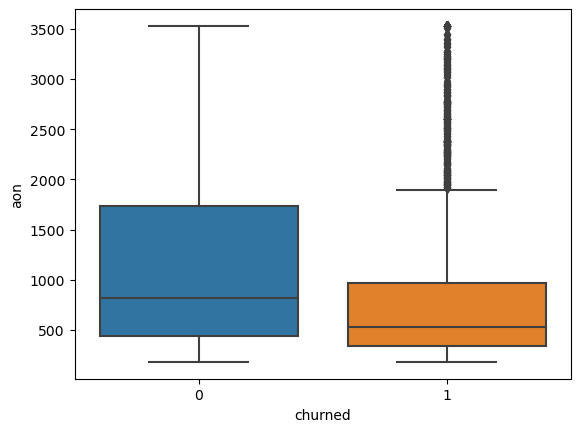

In [457]:
sns.boxplot(x=High_value_customers['churned'], y=High_value_customers['aon'])
plt.show()

In [458]:
print("Average age of network for non-churned customers")
print(High_value_customers[High_value_customers['churned'] == 0][['aon']].mean())

print("Average age of network for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1][['aon']].mean())

Average age of network for non-churned customers
aon    1183.359858
dtype: float64
Average age of network for Churned customers
aon    799.99552
dtype: float64


**Customers who are relatively new are at a higher risk of churning.**

In [459]:
print("Non-churned Customers")
print(High_value_customers[High_value_customers["churned"] == 0]['derived_total_rech_num'].value_counts(normalize=True))

print("Churned Customers")
print(High_value_customers[High_value_customers["churned"] == 1]['derived_total_rech_num'].value_counts(normalize=True))

Non-churned Customers
 1.00     0.065154
 0.50     0.064759
 1.50     0.062349
 2.00     0.061882
 2.50     0.055697
 0.00     0.055625
-0.50     0.051383
 3.00     0.046205
-7.75     0.046133
-1.00     0.043688
 3.50     0.040092
-1.50     0.035490
 4.00     0.032541
-2.00     0.030599
-2.50     0.028262
 4.50     0.028262
 10.25    0.025781
-3.00     0.021826
 5.00     0.020531
-3.50     0.018302
 5.50     0.018194
-4.50     0.015174
-4.00     0.014994
 6.00     0.014311
-5.00     0.012549
 6.50     0.010679
 7.00     0.009780
-5.50     0.009241
 7.50     0.008702
-6.00     0.008198
-6.50     0.008018
 8.00     0.006940
-7.50     0.005717
 8.50     0.005717
-7.00     0.005645
 9.00     0.004135
 9.50     0.003811
 10.00    0.003632
Name: derived_total_rech_num, dtype: float64
Churned Customers
 10.25    0.125049
 1.00     0.059603
 3.00     0.055317
 1.50     0.050253
 2.00     0.047916
 2.50     0.047916
 0.50     0.045578
 4.50     0.044799
 3.50     0.044410
 4.00     0.039735
 5.

- A negative value of 'derived_total_rech_num' indicates an increase in the total recharge number during the action phase. Among retained customers, there's a notable proportion for whom the total number of recharges increased.

- Conversely, a positive value of 'derived_total_rech_num' suggests a decrease in the total recharge number during the action phase. Approximately 12% of churned customers experienced a drop of 10 in their total number of recharges during this phase.

- This derived feature provides a comparative measure between the total number of recharges in the good phase and the action phase, making fractions an acceptable representation.

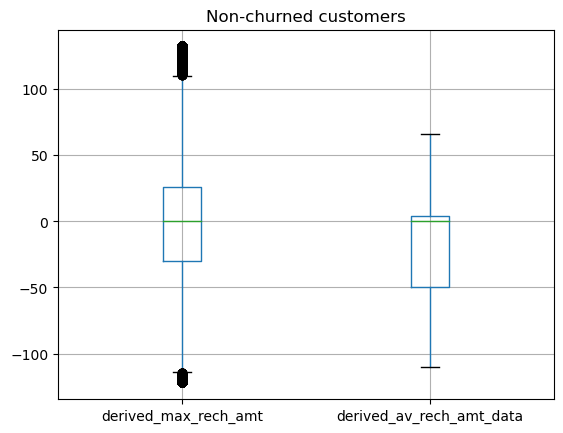

In [460]:
High_value_customers[High_value_customers['churned'] == 0][['derived_max_rech_amt', 'derived_av_rech_amt_data']].boxplot()
plt.title("Non-churned customers")
plt.show()

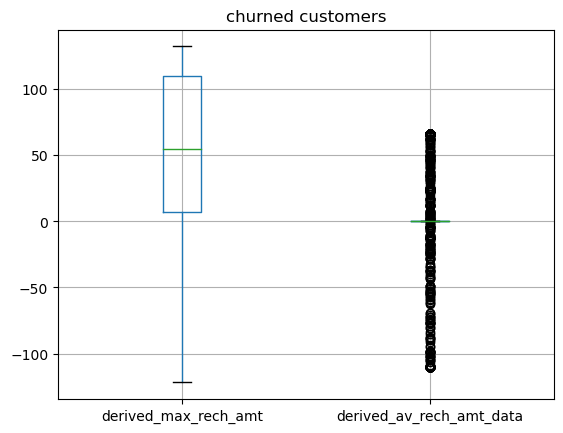

In [461]:
High_value_customers[High_value_customers['churned'] == 1][['derived_max_rech_amt', 'derived_av_rech_amt_data']].boxplot()
plt.title("churned customers")
plt.show()

Positive values of 'derived_max_rech_amt' and 'derived_av_rech_amt_data' signify a decrease in the maximum recharge amount and recharge data during the action phase. This decrease suggests a higher probability of customer churn.

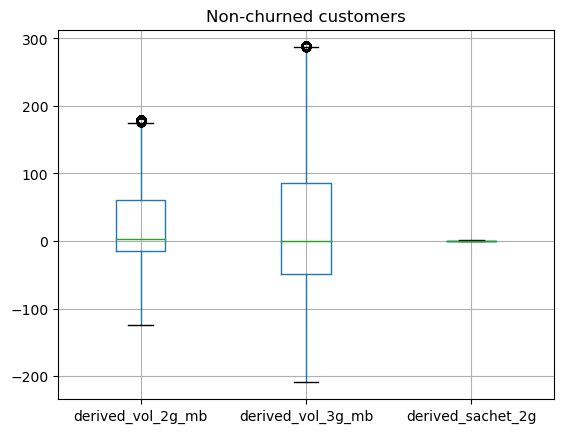

In [462]:
High_value_customers[High_value_customers['churned'] == 0][['derived_vol_2g_mb','derived_vol_3g_mb','derived_sachet_2g']].boxplot()
plt.title("Non-churned customers")
plt.show()

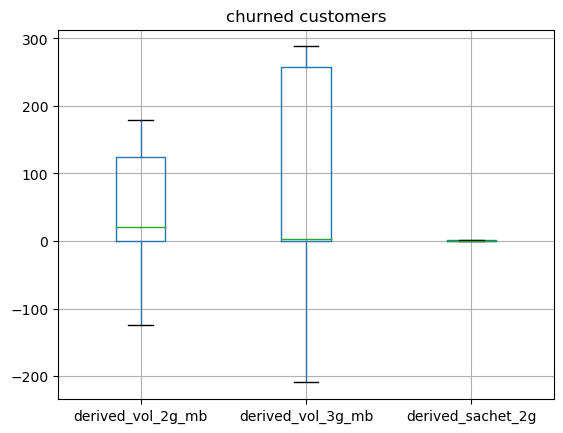

In [463]:
High_value_customers[High_value_customers['churned'] == 1][['derived_vol_2g_mb','derived_vol_3g_mb','derived_sachet_2g']].boxplot()
plt.title("churned customers")
plt.show()

High positive values of 'derived_vol_3g_mb' for churned customers indicate a substantial drop in 3G data usage during the action phase for customers who eventually churned. Conversely, 2G data is not a strong indicator for churn.

# Recommendation for Reducing Customer Churn:

### Feature Related Recommendations:

1. Customers with 'no_of_days_since_last_rech' 17 or more are most likely churn. **Sales team may focus on customers who have not made a recharge in last 17 days or more and provide them with special talk-time offers to reduce churn.**

2. Customers with 'no_of_days_since_last_rech_data' 50 or more are most likely churn. **Sales team may focus on customers who have not made a recharge for mobile data in last 1.5 months or more and provide them with special data recharge offers to reduce churn.**

3. Customers with high positive values in 'derived_loc_ic_t2m_mou' are going to churn. **Drop in incoming call usage can signify customer churn. Company needs to revise its plans and offer customers with suitable plans if incoming calls are charged. Incoming calls may reduce for poor network in customers' current location.**

4. Customers with high positive values in 'derived_last_day_rch_amt' are going to churn. **Sales team may focus on the customer whose derived_last_day_rch_amt >= 35. Drop in last recharge amount in action phase is indicator of churn.**

5. Customers with high positive values in 'derived_arpu' are going to churn. **Sales team may focus on the customer whose derived_arpu > 160. Drop in average revenue per user in action phase is important indicator of customer churn. Revenue is generated by recharges made by the customer, suitable offers can be given to the customer by checking other information such as drop in outgoing calls, drop in data recharge etc.**


6. Customers with aon (age of network) < 800 are more likely to churn than others. **Customers using the telecom operator for more than 1000 days or 3 years are proven to be loyal customers (aon>1000). Churned customers have average aon of 800, that means customers using the telecom operator for 2 years or less (800 days or less) might churn.**

7. **Positive value of 'derived_total_rech_num'> 10 is a strong indicator of churn. About 12 % of the churned customers' total number of recharge dropped by 10 in action phase. Sales team may provide customers with dropping number of recharge with suitable recharge options.** 

8. **Positive values of 'derived_max_rech_amt' and 'derived_av_rech_amt_data' indicate drop in maximum recharge amount and recharge data in action phase, which in turn indicates high probability of Customer churn.**

9. High positive values of 'derived_vol_3g_mb' means for churned customers means huge drop in 3g data usage in action phase for customer who churned. **Telecom company may need to revise its 3g data plans in order to retain customers using 3g data.**

# Conclusion
### Predictor Model
- Since reducing customer churn with attractive offers is less expensive than acquiring new customers, sensitivity score is considered for building the final predictor model.

- Logistic Regression trained with 15 principal components has an accuracy score of 0.78 and a sensitivity score of 0.78 for Probability Cutoff = 0.5.

- The final model could correctly predict 78% of the churned customers out of all the churned customers (sensitivity).

- An accuracy score of 0.78 means that 78% of the predictions made by the final model are correct out of all the predictions.

### Interpretable Model
The top 14 features selected by RFE and manual inspection of VIF and p-values are:

- 'aon'
- 'no_of_days_since_last_rech'
- 'no_of_days_since_last_rech_data'
- 'derived_arpu'
- 'derived_loc_og_t2f_mou'
- 'derived_loc_og_t2c_mou'
- 'derived_loc_ic_t2t_mou'
- 'derived_loc_ic_t2m_mou'
- 'derived_total_ic_mou'
- 'derived_max_rech_amt'
- 'derived_last_day_rch_amt'
- 'derived_av_rech_amt_data'
- 'derived_sachet_2g'
- 'derived_vbc_3g'


**A Logistic Regression model is built with the above features.**